<a href="https://colab.research.google.com/github/estevaovukelic/Regressions/blob/main/RossmannStoreSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATASET: [Rossmann Store Sales from Kaggle.](https://)

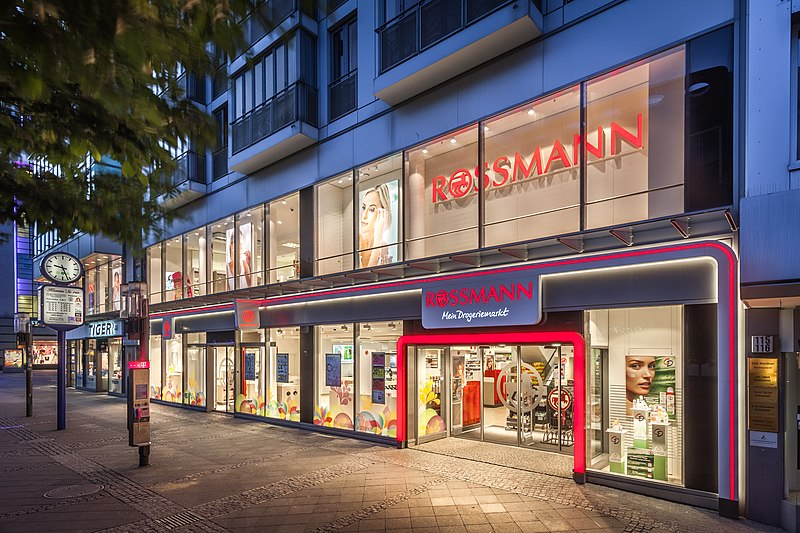

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# 0.0. IMPORTS OF LIBRARIES

In [ ]:
pip install boruta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import seaborn as sns
sns.set()
import matplotlib.gridspec as gridspec
import plotly.express as px
import xgboost as xgb

from IPython.display       import Image
from scipy                 import stats
from boruta                import BorutaPy
from datetime              import datetime, timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso


## 0.1. FUNCTIONS

## 0.2. LOAD DATA

*   ROSSMANN DAILY SALES DATASET
*   ROSSMANN DRUGSTORES DATASET

In [ ]:
df_ross_sales = pd.read_csv('/gdrive/MyDrive/RossmannStoreSales/train.csv',low_memory=False)
df_ross_store = pd.read_csv('/gdrive/MyDrive/RossmannStoreSales/store.csv', low_memory=False)

## Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

*   Id - an Id that represents a (Store, Date) duple within the test set
*   Store - a unique Id for each store
*   Sales - the turnover for any given day (this is what you are predicting)
*   Customers - the number of customers on a given day
*   Open - an indicator for whether the store was open: 0 = closed, 1 = open
*   StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
*   SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
*   StoreType - differentiates between 4 different store models: a, b, c, d
*   Assortment - describes an assortment level: a = basic, b = extra, c = extended
*   CompetitionDistance - distance in meters to the nearest competitor store
*   CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
*   Promo - indicates whether a store is running a promo on that day
*   Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
*   Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
*   PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
df_ross_sales

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [ ]:
df_ross_store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
df_ross_store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


#### 0.2.1. MERGE DATASETS: DAILY SALES AND DRUGSTORES

In [ ]:
df_rossmann = pd.merge(df_ross_sales,df_ross_store, how='left', on='Store')

In [ ]:
df_rossmann.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. DESCRIPTION OF DATA

In [ ]:
df_1 = df_rossmann.copy()

In [ ]:
print(df_1['Store'],[len(df_1['Store'])==250])

0             1
1             2
2             3
3             4
4             5
           ... 
1017204    1111
1017205    1112
1017206    1113
1017207    1114
1017208    1115
Name: Store, Length: 1017209, dtype: int64 [False]


## 1.1. DATA DIMENSIONS

In [ ]:
Dimensions_df = pd.DataFrame({'Number of rows':[df_1.shape[0]], 'Number of columns':[df_1.shape[1]]})
Dimensions_df

,Number of rows,Number of columns
0,1017209,18


In [ ]:
print(f'Number of rows   : {df_1.shape[0]}')
print(f'Number of columns: {df_1.shape[1]}')

Number of rows   : 1017209
Number of columns: 18


## 1.2. DATA TYPES

In [ ]:
df_1.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

#### 1.2.1. CONVERT DATE FIELD (OBJECT TYPE) TO (DATE TYPE)

In [ ]:
df_1['Date'] = pd.to_datetime(df_1['Date'])

In [ ]:
df_1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## 1.3. CHECK AND VIEW DATA WITH THE HEATMAP 

#### 1.3.1. VIEW NULL DATA

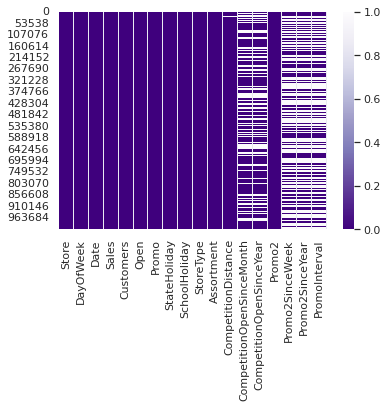

In [ ]:
sns.heatmap(df_1.isnull(),cmap='Purples_r');

#### 1.3.2. NULL DATA NUMBERS

In [ ]:
df_1.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [ ]:
df_1.sample(4)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
573781,342,7,2014-02-02,0,0,0,0,0,0,d,c,15770.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
114553,824,1,2015-04-20,6932,938,1,0,0,0,a,a,17570.0,NaN,NaN,0,NaN,NaN,NaN
424531,502,1,2014-06-16,14477,1783,1,1,0,0,a,a,220.0,2.0,2002.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
338455,201,6,2014-09-13,4837,457,1,0,0,0,d,a,20260.0,NaN,NaN,1,18.0,2014.0,"Mar,Jun,Sept,Dec"


## 1.4. FILL OUT THE NULL DATA

#### 1.4.1. FILL OUT NULL DATA OF THE **CompetitionDistance** WITH MEDIAN

In [ ]:
df_1['CompetitionDistance'].mean()

5430.085652302903

In [ ]:
df_1['CompetitionDistance'].median()

2330.0

In [ ]:
5430/2330

2.3304721030042916

#### Replace null data with median values, in this case, the average is 133% higher.

In [ ]:
df_1['CompetitionDistance'].fillna(df_1['CompetitionDistance'].median(), inplace = True)

#### 1.4.2 FILL ***NA*** OF THE **CompetitionOpenSinceMonth** WITH THE CORRESPONDING MONTH OF THE REGISTER **Data**.

In [ ]:
df_1['CompetitionOpenSinceMonth'] = df_1.apply(lambda x: x['Date'].month if math.isnan(x['CompetitionOpenSinceMonth']) else x['CompetitionOpenSinceMonth'],axis=1)

#### 1.4.3 FILL ***NA*** OF THE **CompetitionOpenSinceYear** WITH THE CORRESPONDING YEAR OF THE REGISTER **Data**.

In [ ]:
df_1['CompetitionOpenSinceYear'] = df_1.apply(lambda x: x['Date'].year if math.isnan(x['CompetitionOpenSinceYear']) else x['CompetitionOpenSinceYear'],axis=1)

#### 1.4.4 FILL ***NA*** OF THE **Promo2SinceWeek** WITH THE CORRESPONDING YEAR OF THE REGISTER **Data**.

In [ ]:
df_1['Promo2SinceWeek'] = df_1.apply(lambda x: x['Date'].week if math.isnan(x['Promo2SinceWeek']) else x['Promo2SinceWeek'],axis=1)

#### 1.4.5 FILL ***NA*** OF THE **Promo2SinceYear** WITH THE CORRESPONDING YEAR OF THE REGISTER **Data**.

In [ ]:
df_1['Promo2SinceYear'] = df_1.apply(lambda x: x['Date'].year if math.isnan(x['Promo2SinceYear']) else x['Promo2SinceYear'],axis=1)

#### 1.4.6 FILL ***NA*** OF THE **PromoInterval** WITH **0**.

In [ ]:
df_1['PromoInterval'].fillna(0, inplace = True)

#### 1.4.7 CREATE NEW FEATURE **MonthMap** THROUGH FEATURE **Date**.

In [ ]:
MonthMap = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dez'}
df_1['MonthMap'] = df_1['Date'].dt.month.map(MonthMap)

#### 1.4.8 CREATE NEW FEATURE **Promo1** WITH **PromoInterval** AND **MonthMap** FEATURES.
IF THE MONTH OF **MonthMap** IS CONTAINED IN **PromoInterval**, **Promo1** WILL BE = 1, OTHERWISE **Promo1** WILL BE = 0.

In [ ]:
df_1['Promo1'] = df_1[['PromoInterval', 'MonthMap']].apply(lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['MonthMap'] in x['PromoInterval'].split(',') else 0, axis=1)

In [ ]:
df_1.sample(6).T

,245469,249240,565316,84841,587000,228648
Store,811,846,797,102,181,74
DayOfWeek,1,4,1,6,2,3
Date,2014-12-22 00:00:00,2014-12-18 00:00:00,2014-02-10 00:00:00,2015-05-16 00:00:00,2014-01-21 00:00:00,2015-01-07 00:00:00
Sales,6436,14461,3162,5570,8932,6861
Customers,949,1142,343,877,794,961
Open,1,1,1,1,1,1
Promo,0,1,0,0,1,1
StateHoliday,0,0,0,0,0,0
SchoolHoliday,1,0,0,0,0,0
StoreType,a,a,a,a,a,a


In [ ]:
df_1.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
MonthMap                     0
Promo1                       0
dtype: int64

## 1.5. CHANGE TYPES

In [ ]:
df_1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
MonthMap                             object
Promo1                                int64
dtype: object

#### 1.5.1 CHANGE THE VARIABLES FROM FLOAT TO INTEGER:

*   CompetitionOpenSinceMonth
*   CompetitionOpenSinceYear
*   Promo2SinceWeek
*   Promo2SinceYear

In [ ]:
df_1['CompetitionOpenSinceMonth'] = df_1['CompetitionOpenSinceMonth'].astype(int)
df_1['CompetitionOpenSinceYear']  = df_1['CompetitionOpenSinceYear'].astype(int)
df_1['Promo2SinceWeek'] = df_1['Promo2SinceWeek'].astype(int)
df_1['Promo2SinceYear'] = df_1['Promo2SinceYear'].astype(int)

In [ ]:
df_1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int64
CompetitionOpenSinceYear              int64
Promo2                                int64
Promo2SinceWeek                       int64
Promo2SinceYear                       int64
PromoInterval                        object
MonthMap                             object
Promo1                                int64
dtype: object

## 1.6. DESCRIPTIVE STATISTICAL

In [ ]:
numeric_variables = df_1.select_dtypes(include = ['int64', 'float64'])
categorical_variables = df_1.select_dtypes( exclude = ['datetime64', 'int64', 'float64'])

#### 1.6.1. DESCRIPTIVE STATISTICS OF THE NUMBER ATTRIBUTES

In [ ]:
MEAN = pd.DataFrame(numeric_variables.apply(np.mean)).T
MEDIAN = pd.DataFrame(numeric_variables.apply(np.median)).T
STD = pd.DataFrame(numeric_variables.apply(np.std)).T
MIN = pd.DataFrame(numeric_variables.apply(np.min)).T
MAX = pd.DataFrame(numeric_variables.apply(np.max)).T
RANGE = pd.DataFrame(numeric_variables.apply(lambda x: x.max() - x.min())).T
SKEW = pd.DataFrame(numeric_variables.apply(lambda x: x.skew())).T
KURTOSIS = pd.DataFrame(numeric_variables.apply(lambda x: x.kurtosis())).T

In [ ]:
DESCRIP = pd.concat([MIN, MAX, RANGE, MEAN, MEDIAN, STD, SKEW, KURTOSIS]).T.reset_index()
DESCRIP.columns = ['FEATURES', 'MIN', 'MAX', 'RANGE', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURTOSIS']
DESCRIP

,FEATURES,MIN,MAX,RANGE,MEAN,MEDIAN,STD,SKEW,KURTOSIS
0,Store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,DayOfWeek,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,Sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,Customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,Open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,Promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,SchoolHoliday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,CompetitionDistance,20.0,75860.0,75840.0,5422.033790,2330.0,7706.909256,2.933466,13.040563
8,CompetitionOpenSinceMonth,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,CompetitionOpenSinceYear,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### 1.6.2. DISTRIBUTION OF NUMERIC ATTRIBUTES

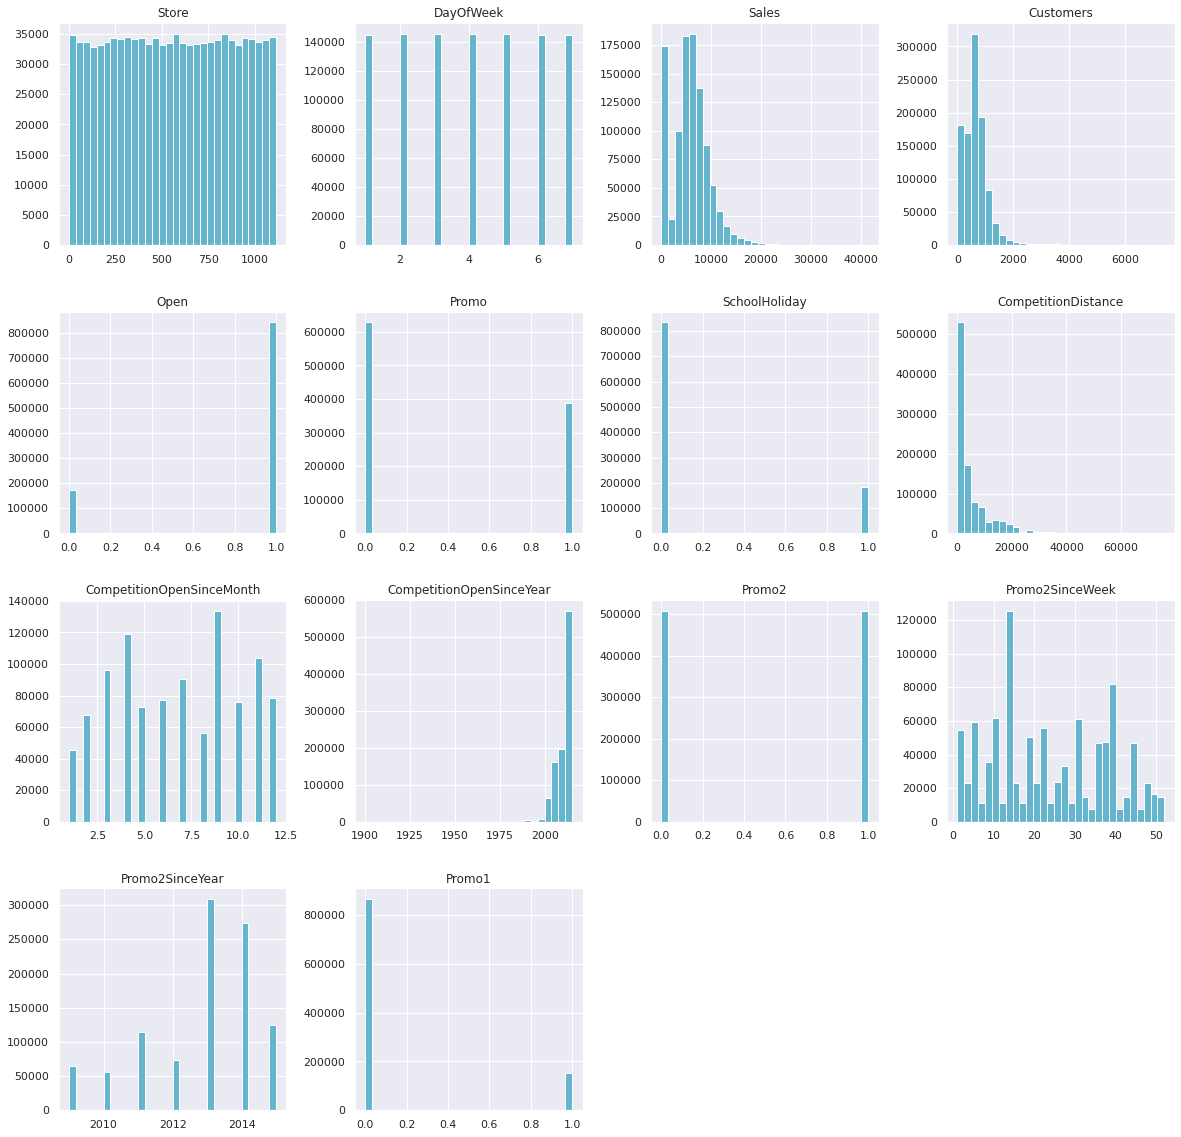

In [ ]:
numeric_variables.hist(bins = 30, figsize=(20,20), color = 'c');

## 1.7. DESCRIPTIVE STATISTICS OF THE CATEGORICAL ATTRIBUTES

In [ ]:
categorical_variables.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1017169,1017170,1017171,1017172,1017173,1017174,1017175,1017176,1017177,1017178,1017179,1017180,1017181,1017182,1017183,1017184,1017185,1017186,1017187,1017188,1017189,1017190,1017191,1017192,1017193,1017194,1017195,1017196,1017197,1017198,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
StateHoliday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a
StoreType,c,a,a,c,a,a,a,a,a,a,a,a,d,a,d,a,a,d,a,d,c,a,d,a,c,d,a,a,d,a,d,a,a,c,d,a,c,d,a,a,...,a,a,d,a,a,b,c,d,a,c,a,d,a,d,a,a,a,c,d,a,a,b,a,a,a,d,a,d,d,c,a,a,a,c,c,a,c,a,a,d
Assortment,a,a,a,c,a,a,c,a,c,a,c,c,a,a,c,c,a,c,c,a,c,a,a,c,a,a,a,a,c,a,c,a,c,a,c,c,a,a,a,a,...,c,a,c,a,a,a,a,c,a,a,a,c,a,a,a,c,a,c,a,a,c,b,a,c,a,c,a,c,a,c,c,a,a,a,c,a,c,c,c,c
PromoInterval,0,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,0,0,0,0,0,0,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct","Feb,May,Aug,Nov","Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct","Mar,Jun,Sept,Dec","Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,"Jan,Apr,Jul,Oct",0,0,"Jan,Apr,Jul,Oct","Mar,Jun,Sept,Dec",0,"Mar,Jun,Sept,Dec",0,"Feb,May,Aug,Nov",0,0,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,0,"Feb,May,Aug,Nov","Feb,May,Aug,Nov",...,"Jan,Apr,Jul,Oct","Mar,Jun,Sept,Dec","Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,0,"Feb,May,Aug,Nov","Jan,Apr,Jul,Oct",0,"Feb,May,Aug,Nov",0,"Jan,Apr,Jul,Oct",0,"Jan,Apr,Jul,Oct",0,"Jan,Apr,Jul,Oct",0,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct","Mar,Jun,Sept,Dec",0,0,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,"Jan,Apr,Jul,Oct","Feb,May,Aug,Nov","Jan,Apr,Jul,Oct","Feb,May,Aug,Nov","Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,"Jan,Apr,Jul,Oct",0,"Jan,Apr,Jul,Oct",0,0,0,"Mar,Jun,Sept,Dec"
MonthMap,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,Jul,...,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan,Jan


#### 1.7.1. DISTRIBUTION OF CATEGORICAL ATTRIBUTES

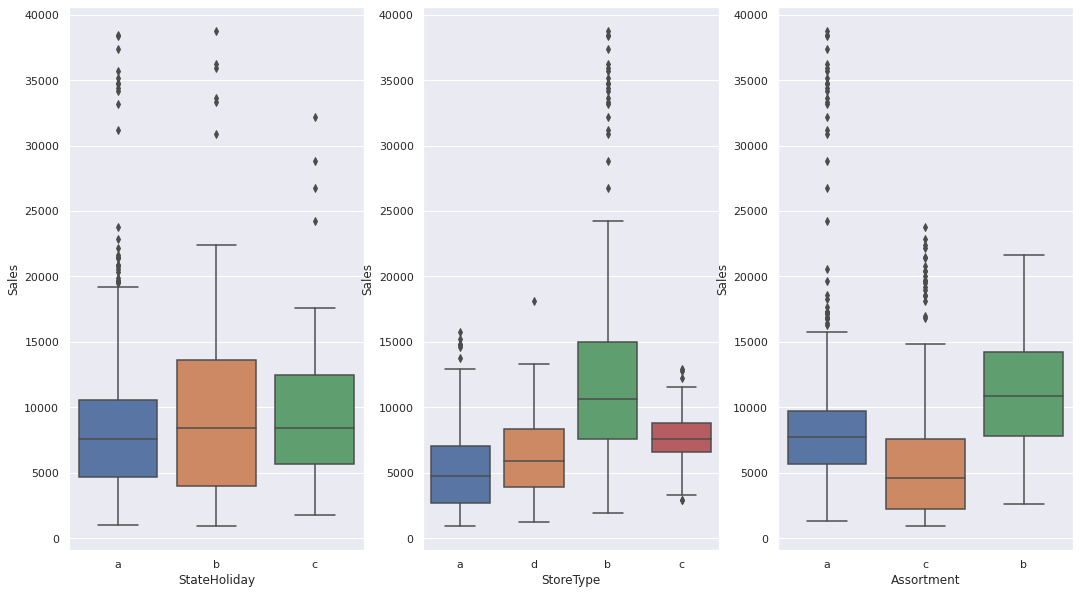

In [ ]:
r = df_1[(df_1['StateHoliday'] != '0') & (df_1['Sales'] > 0)]

plt.figure(figsize=(18, 10))
plt.subplot(1,3,1)
sns.boxplot(x='StateHoliday', y='Sales', data=r);
plt.subplot(1,3,2)
sns.boxplot(x='StoreType', y='Sales', data=r);
plt.subplot(1,3,3)
sns.boxplot(x='Assortment', y='Sales', data=r);


# 2.0. FEATURE ENGINEERING

In [ ]:
df_2 = df_1.copy()
df_2

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,MonthMap,Promo1
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",Jan,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4,2006,0,1,2013,0,Jan,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,1,2013,0,1,2013,0,Jan,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,1,2013,0,1,2013,0,Jan,0


## 2.1. MAP OF HYPOTHESES

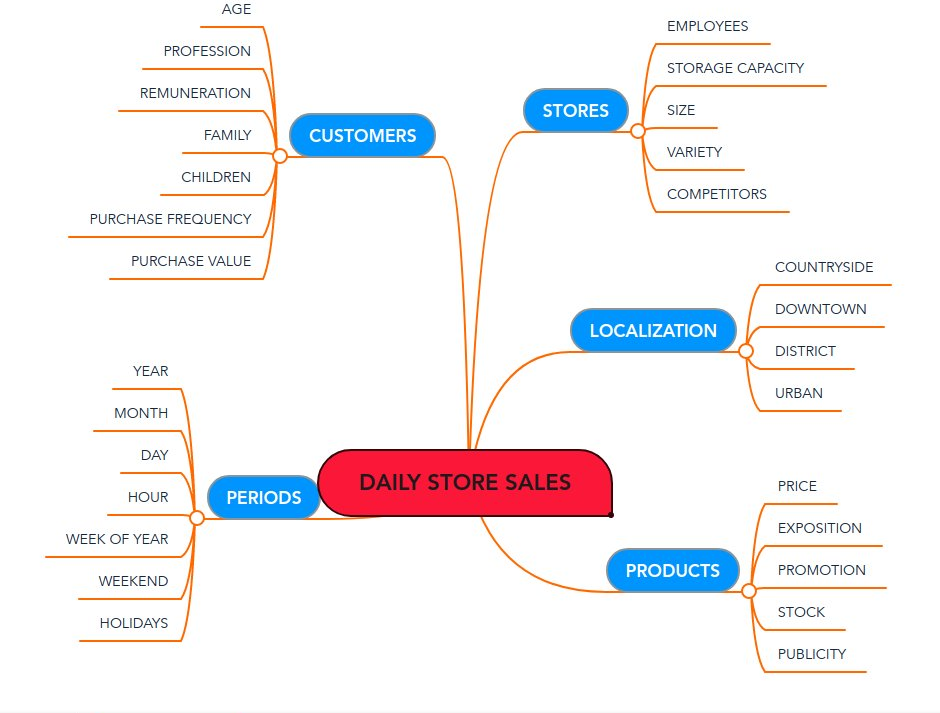

## 2.2. LIST OF HYPOTHESES GENERATED FROM THE DATASET:

1. Stores with a larger assortment sell more.

2. Stores with competition closer sell less.

3. Stores with longer time competition sell more.

4. Stores with longer sales promotions sell more..

5. Stores with consecutive sales promotions sell more.

6. Stores open on Christmas time sell more.

7. Stores sell more over the years.

8. Stores sell more on second semester.

9. Stores sell more after the 10th months day.

10. Stores sell less on weekend.

11. Stores sell less while school vacation.

## 2.3. DERIVING VARIABLES



#### 2.3.1. NEW ATTRIBUTES FROM **Date** DERIVATION:
1.   Year
2.   Month
3.   Day
4.   WeekOfYear
5.   YearWeek


In [ ]:
df_2['Year'] = df_2['Date'].dt.year
df_2['Month'] = df_2['Date'].dt.month
df_2['Day'] = df_2['Date'].dt.day
df_2['WeekOfYear'] = df_2['Date'].dt.isocalendar().week
df_2['YearWeek'] = df_2['Date'].dt.strftime('%Y-%W')

#### 2.3.2. CREATE FEATURE **CompetitionSince** GATHER THE MONTH OF FEATURE **CompetitionOpenSinceMonth** AND THE YEAR OF FEATURE **CompetitionOpenSinceYear**.

In [ ]:
df_2['CompetitionSince'] = df_2.apply(lambda x: datetime(year=x['CompetitionOpenSinceYear'], month=x['CompetitionOpenSinceMonth'], day=1), axis=1)

In [ ]:
df_2['CompetitionSince']

0         2008-09-01
1         2007-11-01
2         2006-12-01
3         2009-09-01
4         2015-04-01
             ...    
1017204   2014-06-01
1017205   2006-04-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: CompetitionSince, Length: 1017209, dtype: datetime64[ns]

#### 2.3.3. CREATE FEATURE **CompetitionTimeMonth** WITH DIFFERENCE BETWEEN **Date** AND **CompetitionSince** AND DIVIDE BY 30 TO FIND THE QUANTITY OF MONTHS.

In [ ]:
df_2['CompetitionTimeMonth'] = ((df_2['Date'] - df_2['CompetitionSince']) / 30).apply(lambda x: x.days).astype(int)

In [ ]:
df_2.sample(5).T

,1015935,775321,713895,502518,645644
Store,956,67,1081,439,845
DayOfWeek,3,1,1,1,6
Date,2013-01-02 00:00:00,2013-08-05 00:00:00,2013-09-30 00:00:00,2014-04-07 00:00:00,2013-11-30 00:00:00
Sales,4072,6503,5835,6381,6061
Customers,620,737,937,853,445
Open,1,1,1,1,1
Promo,0,0,0,0,0
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,0,0
StoreType,a,a,b,a,d


In [ ]:
df_2.query('CompetitionTimeMonth <0')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,MonthMap,Promo1,Year,Month,Day,WeekOfYear,YearWeek,CompetitionSince,CompetitionTimeMonth
687,688,5,2015-07-31,5107,469,1,1,0,1,a,a,18760.0,8,2015,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2015-08-01,-1
1019,1020,5,2015-07-31,10734,1138,1,1,0,1,a,a,40.0,8,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-08-01,-1
1071,1072,5,2015-07-31,10270,817,1,1,0,1,a,c,5380.0,8,2015,1,5,2010,"Feb,May,Aug,Nov",Jul,0,2015,7,31,31,2015-30,2015-08-01,-1
1802,688,4,2015-07-30,4188,416,1,1,0,1,a,a,18760.0,8,2015,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,30,31,2015-30,2015-08-01,-1
2134,1020,4,2015-07-30,8020,943,1,1,0,1,a,a,40.0,8,2015,0,31,2015,0,Jul,0,2015,7,30,31,2015-30,2015-08-01,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017178,1085,2,2013-01-01,0,0,0,0,a,1,c,a,4030.0,2,2015,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2015-02-01,-26
1017179,1086,2,2013-01-01,0,0,0,0,a,1,a,a,180.0,11,2013,1,18,2011,"Feb,May,Aug,Nov",Jan,0,2013,1,1,1,2013-00,2013-11-01,-11
1017187,1094,2,2013-01-01,0,0,0,0,a,1,d,a,2380.0,3,2013,1,40,2014,"Jan,Apr,Jul,Oct",Jan,1,2013,1,1,1,2013-00,2013-03-01,-2
1017192,1099,2,2013-01-01,0,0,0,0,a,1,a,c,200.0,4,2013,1,14,2013,"Jan,Apr,Jul,Oct",Jan,1,2013,1,1,1,2013-00,2013-04-01,-3


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

#### 2.3.4. CREATE FEATURE **PromoTimeWeek** WITH DIFFERENCE BETWEEN **Date**  AND **PromoSince** AND DIVIDE BY 7 TO FIND THE QUANTITY OF WEEKS.

##### 2.3.4.1 JOIN THE **Promo2SinceYear** AND **Promo2SinceWeek** FEATURES AND CONVERT TO STRING.

In [ ]:
df_2['PromoSince'] = df_2['Promo2SinceYear'].astype(str) + '-' + df_2['Promo2SinceWeek'].astype(str)

##### 2.3.4.2 CONVERT TO DATE AND REPLACE **PromoSince** AND CREATE **PromoTimeWeek**.

In [ ]:
df_2['PromoSince'] = df_2['PromoSince'].apply( lambda x: datetime.strptime( x+'-1', '%Y-%W-%w' ) - timedelta(days=7))
df_2['PromoTimeWeek'] = df_2.apply( lambda x: (( x['Date'] - x['PromoSince'])/7 ).days, axis=1).astype('int64')

#### 2.3.5. IN FEATURE **Assortment** REPLACE LEVELS BY NAMES: a = basic, b = extra, c = extended.

In [ ]:
df_2['Assortment'] = df_2['Assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#### 2.3.6. IN FEATURE **StateHoliday** REPLACE LEVELS BY NAMES: a = public holiday, b = Easter holiday, c = Christmas, 0 = Regular day.

In [ ]:
df_2['StateHoliday'] = df_2['StateHoliday'].apply( lambda x: 'PublicHoliday' if x == 'a' else 'EasterHoliday' if x == 'b' else 'Christmas' if x == 'c' else 'RegularDay')

In [ ]:
df_2.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,RegularDay,RegularDay,RegularDay,RegularDay,RegularDay
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a


# 3.0. FILTER FEATURES

In [ ]:
df_3 = df_2.copy()

In [ ]:
df_3.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,MonthMap,Promo1,Year,Month,Day,WeekOfYear,YearWeek,CompetitionSince,CompetitionTimeMonth,PromoSince,PromoTimeWeek
0,1,5,2015-07-31,5263,555,1,1,RegularDay,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,RegularDay,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,RegularDay,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,RegularDay,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,RegularDay,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [ ]:
#VER DEPOIS 


f_3 = df_3[(df_3['Store'] ==85 ) & (df_3['StoreType'] == 'b')]
f_3

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,MonthMap,Promo1,Year,Month,Day,WeekOfYear,YearWeek,CompetitionSince,CompetitionTimeMonth,PromoSince,PromoTimeWeek
84,85,5,2015-07-31,7791,971,1,1,RegularDay,1,b,basic,1870.0,10,2011,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2011-10-01,46,2015-07-27,0
1199,85,4,2015-07-30,7187,1000,1,1,RegularDay,1,b,basic,1870.0,10,2011,0,31,2015,0,Jul,0,2015,7,30,31,2015-30,2011-10-01,46,2015-07-27,0
2314,85,3,2015-07-29,7719,889,1,1,RegularDay,1,b,basic,1870.0,10,2011,0,31,2015,0,Jul,0,2015,7,29,31,2015-30,2011-10-01,46,2015-07-27,0
3429,85,2,2015-07-28,7533,920,1,1,RegularDay,1,b,basic,1870.0,10,2011,0,31,2015,0,Jul,0,2015,7,28,31,2015-30,2011-10-01,46,2015-07-27,0
4544,85,1,2015-07-27,7788,956,1,1,RegularDay,1,b,basic,1870.0,10,2011,0,31,2015,0,Jul,0,2015,7,27,31,2015-30,2011-10-01,46,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011719,85,6,2013-01-05,5774,772,1,0,RegularDay,0,b,basic,1870.0,10,2011,0,1,2013,0,Jan,0,2013,1,5,1,2013-00,2011-10-01,15,2012-12-31,0
1012834,85,5,2013-01-04,5339,805,1,0,RegularDay,1,b,basic,1870.0,10,2011,0,1,2013,0,Jan,0,2013,1,4,1,2013-00,2011-10-01,15,2012-12-31,0
1013949,85,4,2013-01-03,5246,820,1,0,RegularDay,1,b,basic,1870.0,10,2011,0,1,2013,0,Jan,0,2013,1,3,1,2013-00,2011-10-01,15,2012-12-31,0
1015064,85,3,2013-01-02,6069,914,1,0,RegularDay,1,b,basic,1870.0,10,2011,0,1,2013,0,Jan,0,2013,1,2,1,2013-00,2011-10-01,15,2012-12-31,0


## 3.1. FILTER LINES

#### 3.1.1. REMOVE LINES FROM FEATURE **Open** (CLOSED STORES = 0) AND FROM FEATURE **Sales** = 0.

In [ ]:
df_3 = df_3[(df_3['Open'] != 0 ) & (df_3['Sales'] > 0)]

#### 3.1.2.REMOVING THE COLUMNS: 
*   **Customers** (NO CUSTOMER DATA AT THE TIME OF FORECAST)
*   **Open** (ONLY HAS **VALUE** 1)
*   **PromoInterval** AND **MonthMap** (THE COLUMNS USED TO CREATE THE **PromoTimeMonth** AND **PromoTimeWeek** RESOURCES FULFILLED THEIR OBJECTIVE...



In [ ]:
cols_drop = ['Customers','Open', 'PromoInterval', 'MonthMap']
df_3 = df_3.drop( cols_drop, axis=1 )

# 4.0. EXPLORATORY DATA ANALYSIS

In [ ]:
df_4 = df_3.copy()

## 4.1 UNIVARIATE ANALYSIS

#### 4.1.1. RESPONSE VARIABLE

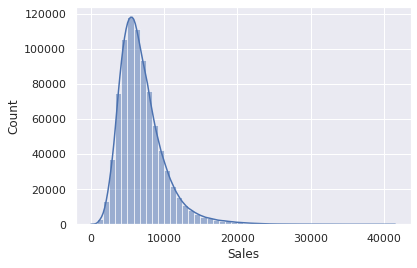

In [ ]:
sns.histplot(df_4['Sales'],bins=50, kde=True);

In [ ]:
df_4['Sales'].skew()

1.5949288357537479

In [ ]:
df_4['Sales'].kurtosis()

4.854026585805923

In [ ]:
df_4['Sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

#### 4.1.2. NUMERICAL VARIABLE

In [ ]:
numeric_variables_1 = df_4.select_dtypes(include = ['int64', 'float64'])

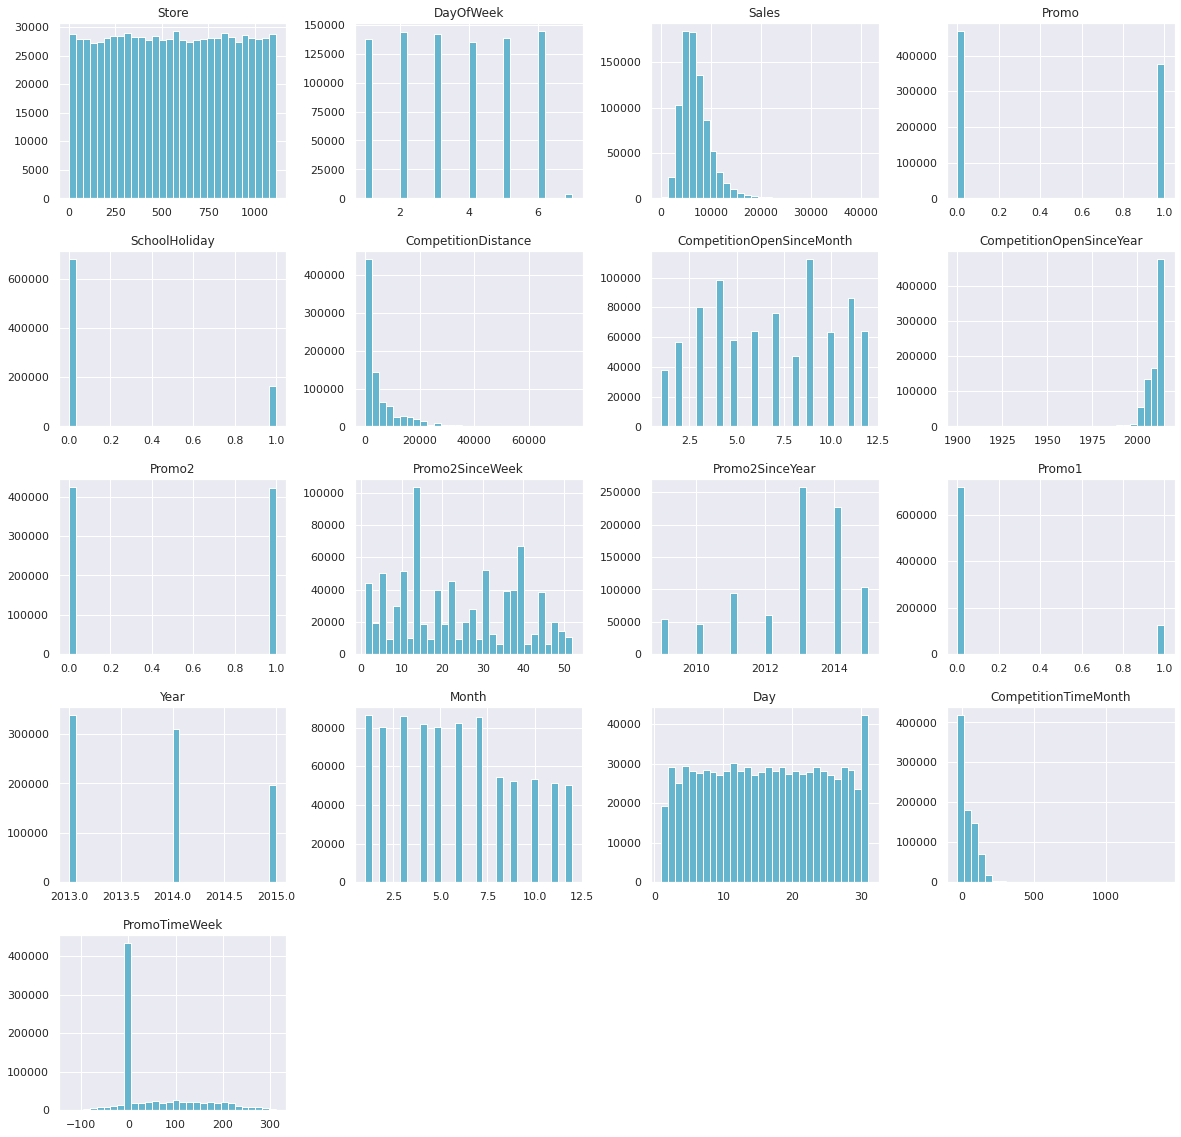

In [ ]:
numeric_variables_1.hist(bins = 30, figsize=(20,20), color = 'c');

#### 4.1.3. CATEGORICAL VARIABLES

In [ ]:
categorical_variables_1 = df_4.select_dtypes( exclude = ['datetime64', 'int64', 'float64'])
categorical_variables_1

,StateHoliday,StoreType,Assortment,WeekOfYear,YearWeek
0,RegularDay,c,basic,31,2015-30
1,RegularDay,a,basic,31,2015-30
2,RegularDay,a,basic,31,2015-30
3,RegularDay,c,extended,31,2015-30
4,RegularDay,a,basic,31,2015-30
...,...,...,...,...,...
1016776,PublicHoliday,b,basic,1,2013-00
1016827,PublicHoliday,b,extra,1,2013-00
1016863,PublicHoliday,b,extra,1,2013-00
1017042,PublicHoliday,b,extra,1,2013-00


In [ ]:
categorical_variables_1.nunique(axis=0)

StateHoliday      4
StoreType         4
Assortment        3
WeekOfYear       52
YearWeek        137
dtype: int64

##### 4.1.3.1. StateHoliday

In [ ]:
a_1 = df_4[['StateHoliday', 'Sales']].groupby( 'StateHoliday' ).count().reset_index().sort_values(by='Sales', ascending=False)
a_1

,StateHoliday,Sales
3,RegularDay,843428
2,PublicHoliday,694
1,EasterHoliday,145
0,Christmas,71


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


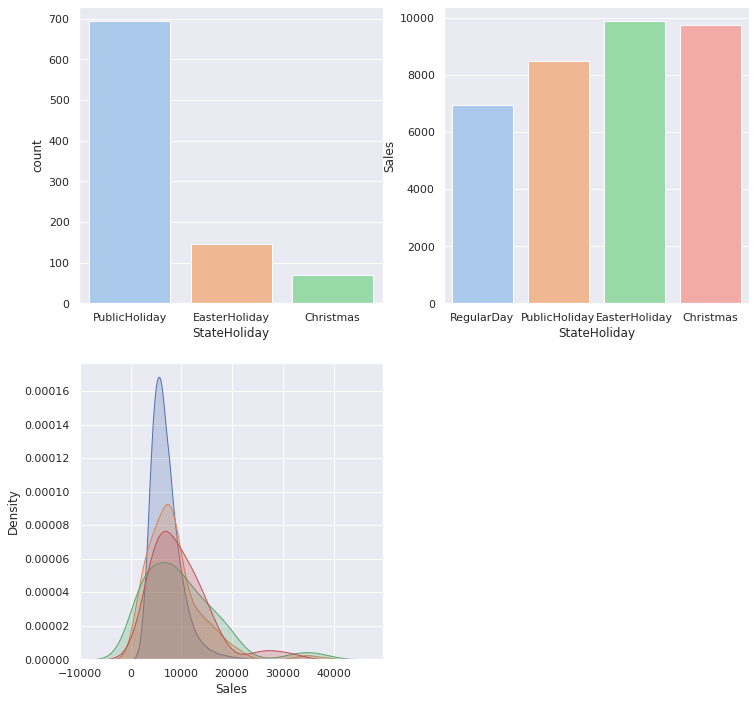

In [ ]:
f, axes = plt.subplots(1,3, figsize=(12, 12))

plt.subplot( 2, 2, 1)
a = df_4[df_4['StateHoliday'] != 'RegularDay']
sns.countplot( a['StateHoliday'],palette='pastel' );

plt.subplot( 2, 2, 2 )
a_1 = df_4[['StateHoliday', 'Sales']].groupby( 'StateHoliday' ).mean().reset_index().sort_values(by='Sales', ascending=True)
a_1
sns.barplot(x='StateHoliday', y="Sales", data=a_1,palette='pastel', order=["RegularDay","PublicHoliday", "EasterHoliday", "Christmas"]);


plt.subplot( 2, 2, 3 )
sns.kdeplot( df_4[df_4['StateHoliday'] == 'RegularDay']['Sales'], label='RegularDay', shade=True);
sns.kdeplot( df_4[df_4['StateHoliday'] == 'PublicHoliday']['Sales'], label='PublicHoliday', shade=True);
sns.kdeplot( df_4[df_4['StateHoliday'] == 'EasterHoliday']['Sales'], label='EasterHoliday', shade=True);
sns.kdeplot( df_4[df_4['StateHoliday'] == 'Christmas']['Sales'], label='Christmas', shade=True);


##### 4.1.3.2. StoreType

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


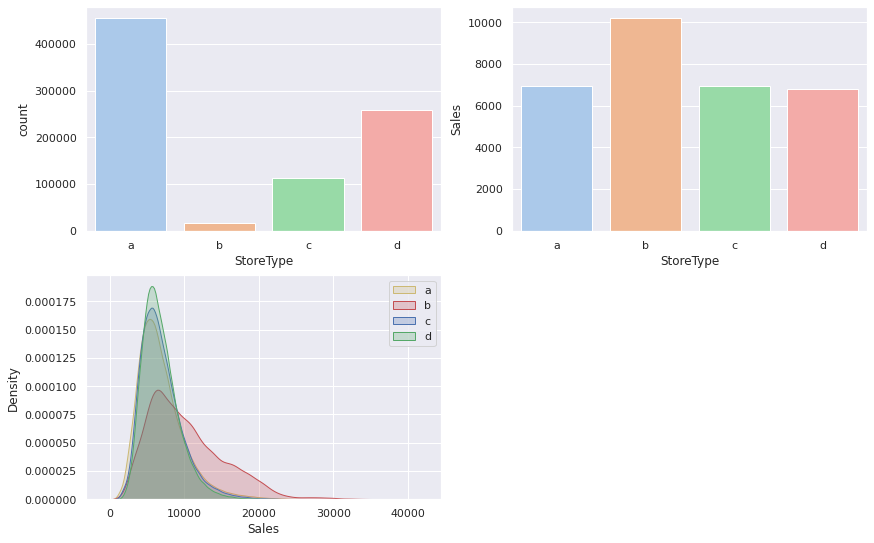

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(14, 14))
plt.subplot( 3, 2, 1 )
sns.countplot( df_4['StoreType'],order=["a", "b", "c", "d"],palette='pastel' );

plt.subplot( 3, 2, 2 )
b_1 = df_4[['StoreType', 'Sales']].groupby( 'StoreType' ).mean().reset_index()
b_1
sns.barplot(x= 'StoreType', y="Sales", data= b_1, order=["a", "b", "c", "d"],palette='pastel');

plt.subplot( 3, 2, 3 )
sns.kdeplot( df_4[df_4['StoreType'] == 'a']['Sales'], color='y', label='a', shade=True);
sns.kdeplot( df_4[df_4['StoreType'] == 'b']['Sales'], color='r',label='b', shade=True);
sns.kdeplot( df_4[df_4['StoreType'] == 'c']['Sales'], color='b',label='c', shade=True);
sns.kdeplot( df_4[df_4['StoreType'] == 'd']['Sales'], color='g',label='d', shade=True);
plt.legend();

In [ ]:
#b_1 = df_4[['StoreType','Assortment' 'Sales']].groupby( 'StoreType' ).mean().reset_index()
#b_1

##### 4.1.3.3. Assortment

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


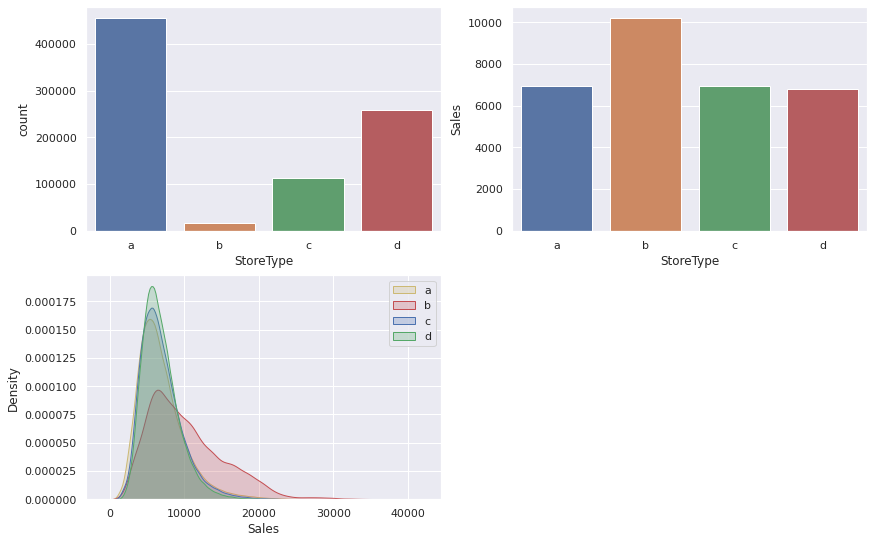

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(14, 14))
plt.subplot( 3, 2, 1 )
sns.countplot( df_4['StoreType'],order=["a", "b", "c", "d"] );

plt.subplot( 3, 2, 2 )
b_1 = df_4[['StoreType', 'Sales']].groupby( 'StoreType' ).mean().reset_index().sort_values(by='Sales', ascending=True)
b_1
sns.barplot(x= 'StoreType', y="Sales", data= b_1, order=["a", "b", "c", "d"]);

plt.subplot( 3, 2, 3 )
sns.kdeplot( df_4[df_4['StoreType'] == 'a']['Sales'], color='y', label='a', shade=True);
sns.kdeplot( df_4[df_4['StoreType'] == 'b']['Sales'], color='r',label='b', shade=True);
sns.kdeplot( df_4[df_4['StoreType'] == 'c']['Sales'], color='b',label='c', shade=True);
sns.kdeplot( df_4[df_4['StoreType'] == 'd']['Sales'], color='g',label='d', shade=True);
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


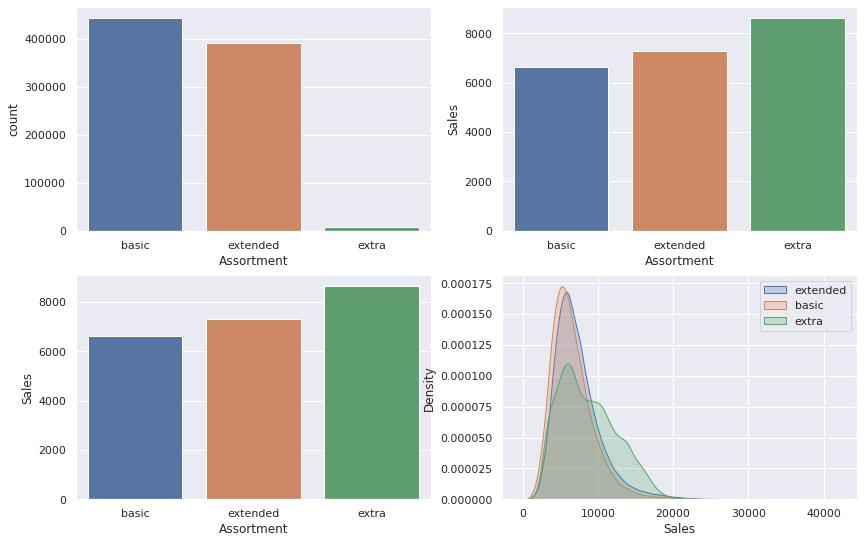

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(14, 14));

plt.subplot( 3, 2, 1 );
sns.countplot( df_4['Assortment'] );

plt.subplot( 3, 2, 2 );
c_1 = df_4[['StoreType','Assortment', 'Sales']].groupby( 'Assortment' ).mean().reset_index().sort_values(by='Sales', ascending=True);
c_1
sns.barplot(x= 'Assortment', y="Sales", data= c_1, order=["basic", "extended", "extra"]);

plt.subplot( 3, 2, 3 );
c_1 = df_4[['StoreType','Assortment', 'Sales']].groupby( 'Assortment' ).mean().reset_index().sort_values(by='Sales', ascending=True);
c_1
sns.barplot(x= 'Assortment', y="Sales", data= c_1, order=["basic", "extended", "extra"]);


plt.subplot( 3, 2, 4);
sns.kdeplot( df_4[df_4['Assortment'] == 'extended']['Sales'], label='extended', shade=True);
sns.kdeplot( df_4[df_4['Assortment'] == 'basic']['Sales'], label='basic', shade=True);
sns.kdeplot( df_4[df_4['Assortment'] == 'extra']['Sales'], label='extra', shade=True);
plt.legend()

In [ ]:
w = np.unique(df_4['Assortment'], return_counts=True)
print(w)

(array(['basic', 'extended', 'extra'], dtype=object), array([444875, 391254,   8209]))


In [ ]:
# confusion matrix makes all the possible combinations between categorical variables
# and count the number of lines of that combination.

o = df_4[(df_4['StateHoliday'] == 'Christmas' ) & ( df_4['StoreType'] == 'b' )]
o

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Promo1,Year,Month,Day,WeekOfYear,YearWeek,CompetitionSince,CompetitionTimeMonth,PromoSince,PromoTimeWeek
241126,85,5,2014-12-26,9741,0,Christmas,1,b,basic,1870.0,10,2011,0,52,2014,0,2014,12,26,52,2014-51,2011-10-01,39,2014-12-22,0
241267,259,5,2014-12-26,17597,0,Christmas,1,b,extra,210.0,12,2014,0,52,2014,0,2014,12,26,52,2014-51,2014-12-01,0,2014-12-22,0
241270,262,5,2014-12-26,32169,0,Christmas,1,b,basic,1180.0,5,2013,0,52,2014,0,2014,12,26,52,2014-51,2013-05-01,20,2014-12-22,0
241281,274,5,2014-12-26,7818,0,Christmas,1,b,extra,3640.0,12,2014,1,10,2013,0,2014,12,26,52,2014-51,2014-12-01,0,2013-03-04,94
241332,335,5,2014-12-26,5784,0,Christmas,1,b,basic,90.0,12,2014,1,31,2013,0,2014,12,26,52,2014-51,2014-12-01,0,2013-07-29,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617657,733,3,2013-12-25,12223,0,Christmas,1,b,extra,860.0,10,1999,0,52,2013,0,2013,12,25,52,2013-51,1999-10-01,173,2013-12-23,0
617693,769,3,2013-12-25,10033,0,Christmas,1,b,extra,840.0,12,2013,1,48,2012,0,2013,12,25,52,2013-51,2013-12-01,0,2012-11-19,57
617872,948,3,2013-12-25,7138,0,Christmas,1,b,extra,1430.0,12,2013,0,52,2013,0,2013,12,25,52,2013-51,2013-12-01,0,2013-12-23,0
618005,1081,3,2013-12-25,1929,0,Christmas,1,b,basic,400.0,3,2006,0,52,2013,0,2013,12,25,52,2013-51,2006-03-01,95,2013-12-23,0


In [ ]:
p = np.unique(df_4['StoreType'], return_counts=True)
print(p)

(array(['a', 'b', 'c', 'd'], dtype=object), array([457042,  15560, 112968, 258768]))


## 4.2 BIVARIATE ANALYSIS

In [ ]:
df_4.describe()

,Store,DayOfWeek,Sales,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Promo1,Year,Month,Day,WeekOfYear,CompetitionTimeMonth,PromoTimeWeek
count,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,558.421374,3.520350,6955.959134,0.446356,0.193578,5450.057797,6.787355,2010.331102,0.498670,23.629083,2012.797915,0.149141,2013.831945,5.845774,15.835706,23.646946,41.679672,54.400699
std,321.730861,1.723712,3103.815515,0.497114,0.395102,7801.076826,3.309917,5.502628,0.499999,14.288315,1.660125,0.356227,0.777271,3.323959,8.683392,14.389931,66.814412,85.457559
min,1.000000,1.000000,46.000000,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,0.000000,2013.000000,1.000000,1.000000,1.000000,-32.000000,-126.000000
25%,280.000000,2.000000,4859.000000,0.000000,0.000000,710.000000,4.000000,2008.000000,0.000000,12.000000,2012.000000,0.000000,2013.000000,3.000000,8.000000,11.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,0.000000,0.000000,2330.000000,7.000000,2012.000000,0.000000,22.000000,2013.000000,0.000000,2014.000000,6.000000,16.000000,23.000000,16.000000,0.000000
75%,837.000000,5.000000,8360.000000,1.000000,0.000000,6880.000000,10.000000,2014.000000,1.000000,37.000000,2014.000000,0.000000,2014.000000,8.000000,23.000000,35.000000,74.000000,109.000000
max,1115.000000,7.000000,41551.000000,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,52.000000,2015.000000,1.000000,2015.000000,12.000000,31.000000,52.000000,1407.000000,313.000000


#### 4.1.1. HYPOTESE 1: STORE SELLS MORE WITH LOTS OF PRODUCT ASSORTMENT.

TRUE: Stores with BIGGER ASSORTMENT sell MORE.

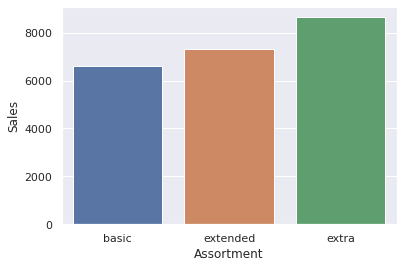

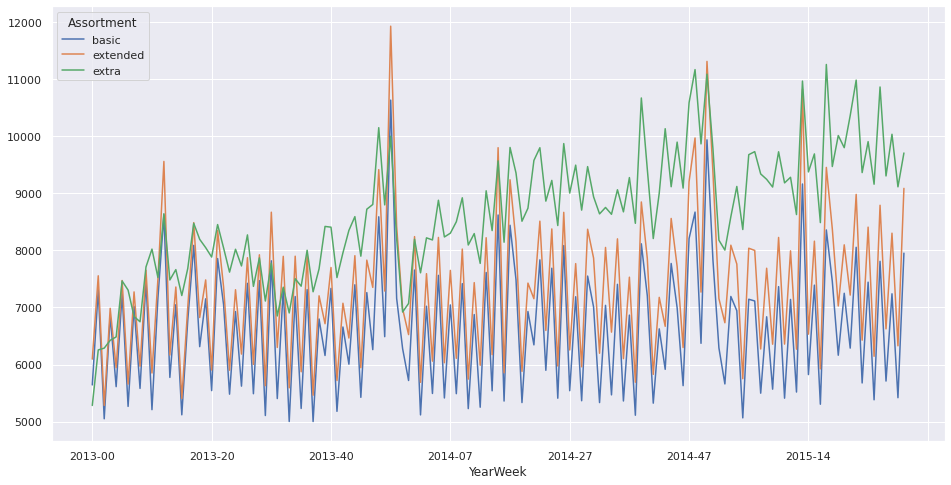

In [ ]:
aux1 = df_4[['Assortment', 'Sales']].groupby( 'Assortment' ).mean().reset_index()
sns.barplot( x='Assortment', y='Sales', data=aux1);

aux2 = df_4[['YearWeek', 'Assortment', 'Sales']].groupby( ['YearWeek', 'Assortment'] ).mean().reset_index()

aux3 = aux2.pivot( index='YearWeek', columns='Assortment', values='Sales')
aux3.head()
aux3.plot(figsize=(16,8))

In [ ]:
aux2.sample(10)

,YearWeek,Assortment,Sales
138,2013-46,basic,7259.356655
222,2014-21,basic,6343.906734
201,2014-14,basic,5539.293853
135,2013-45,basic,5424.990463
190,2014-10,extended,5743.568558
323,2015-01,extra,8589.285714
19,2013-06,extended,5656.864785
81,2013-27,basic,5488.326945
79,2013-26,extended,7870.202725
382,2015-21,extended,7215.485747


In [ ]:
#aux2.sample(10).type








4.1.2. HYPOTESE 2: STORES WITH COMPETITION CLOSER SELL MORE.


FALSE: Stores with COMPETITION CLOSE sell MORE.

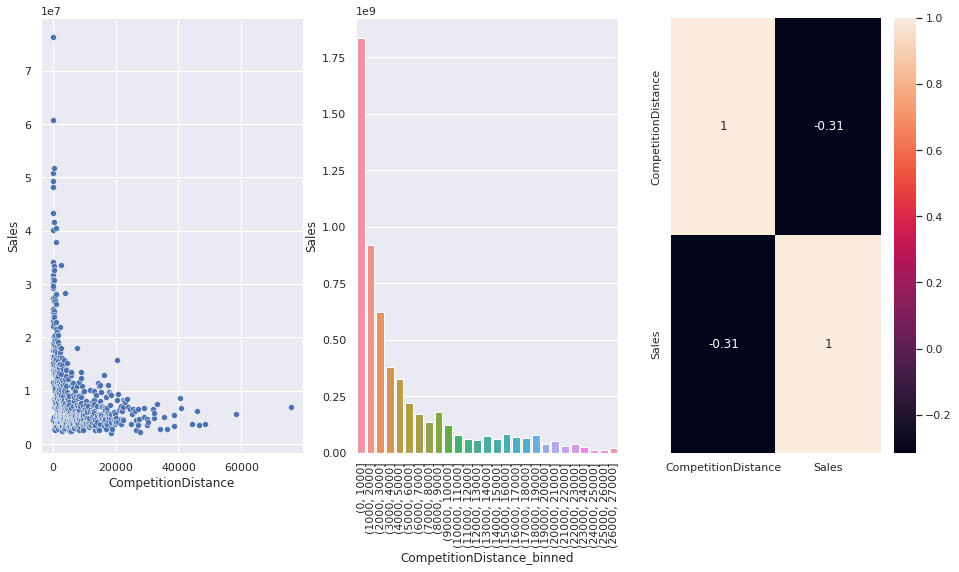

In [ ]:
# sum of sales by competition_distance
aux2_1 = df_4[['CompetitionDistance', 'Sales']].groupby( 'CompetitionDistance' ).sum().reset_index()

# set up figure size
f, ax = plt.subplots( 1, 3, figsize=(16,8))

# grid of plots - 1st plot
plt.subplot( 1, 3, 1 )
# scatter plot competition_distance and sales (aux2_1)
sns.scatterplot( x='CompetitionDistance', y='Sales', data=aux2_1)

# grid of plots - 2nd plot
plt.subplot( 1, 3, 2 )
# create bins to group the values for better plot visualization
bins = list( np.arange( 0, 28000, 1000 ) )
# arrange the values to each corresponding group (bins) 
# and store it in the new column 'competition_distance_binned'.
aux2_1['CompetitionDistance_binned'] = pd.cut( aux2_1['CompetitionDistance'], bins=bins )
# sum of sales by competition_distance_binned
aux2_2 = aux2_1[['CompetitionDistance_binned', 'Sales']].groupby( 'CompetitionDistance_binned' ).sum().reset_index()
# plot sum of sales by competition_distance_binned
sns.barplot( x='CompetitionDistance_binned', y='Sales', data=aux2_2 );
# axis rotation
plt.xticks( rotation=90 )

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3 )
# correlation weight between competition_distance and sales
sns.heatmap( aux2_1.corr( method='pearson' ), annot=True );

In [ ]:
aux2_1.sample(4)

,CompetitionDistance,Sales,CompetitionDistance_binned
392,6360.0,11444198,"(6000, 7000]"
174,1990.0,4810209,"(1000, 2000]"
373,5740.0,4585191,"(5000, 6000]"
216,2540.0,3465390,"(2000, 3000]"


4.1.3. HYPOTESE 3: STORES WITH LONGER TIME COMPETITION SELL MORE.

FALSE Stores with LONGER TIME COMPETITION sell LESS.

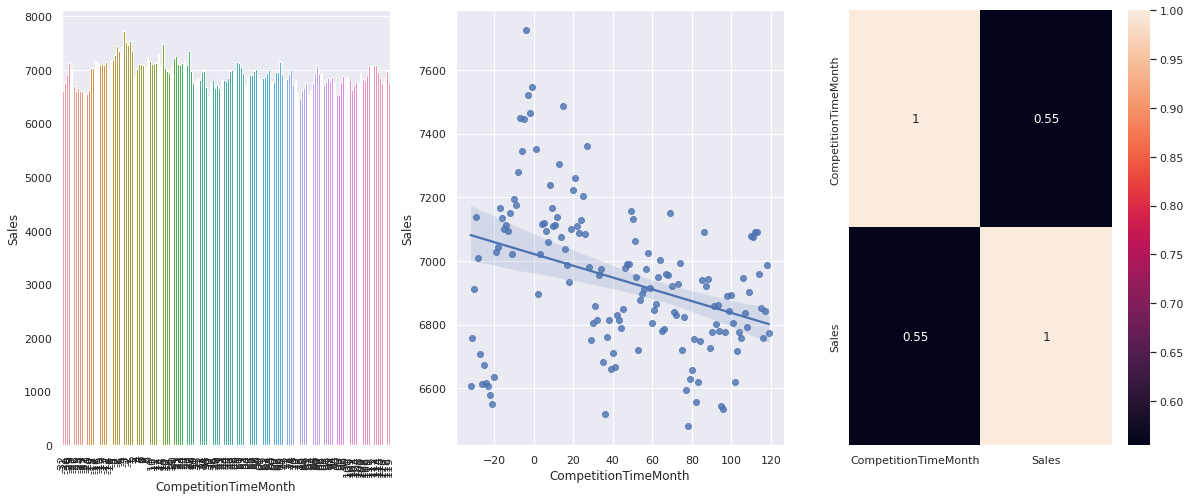

In [ ]:
# sum of sales by competition_time_month
aux3_1 = df_4[['CompetitionTimeMonth', 'Sales']].groupby( 'CompetitionTimeMonth').mean().reset_index()

# Filter values lower than 120 in order to check the first 120 months of competition
# Filter competition time == 0 (competition open in the same month of the sale)
aux3_2 = aux3_1[(aux3_1['CompetitionTimeMonth'] < 120) & ( aux3_1['CompetitionTimeMonth'] != 0 )]

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# grid of plots - 1st plot
plt.subplot( 1, 3, 1)
# bar plot
sns.barplot( x='CompetitionTimeMonth', y='Sales', data=aux3_2)
# rotate x axis labels
plt.xticks( rotation=90 );

# grid of plots - 2nd plot
plt.subplot( 1, 3, 2)
# plot regplot
sns.regplot( x='CompetitionTimeMonth', y='Sales', data=aux3_2);

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3)
sns.heatmap( aux3_1.corr(method='pearson'), annot=True)

# competition time month negative values mean that the competition will open a new store soon in the future.
# the bar plot shows that competition time month values near to zero represents more sales

4.1.4. HYPOTESE 4: STORES WITH LONGER Sale (Promo) SHOULD SELL MORE.

TRUE Stores with longer Sale (promo) sell less after some promo period.

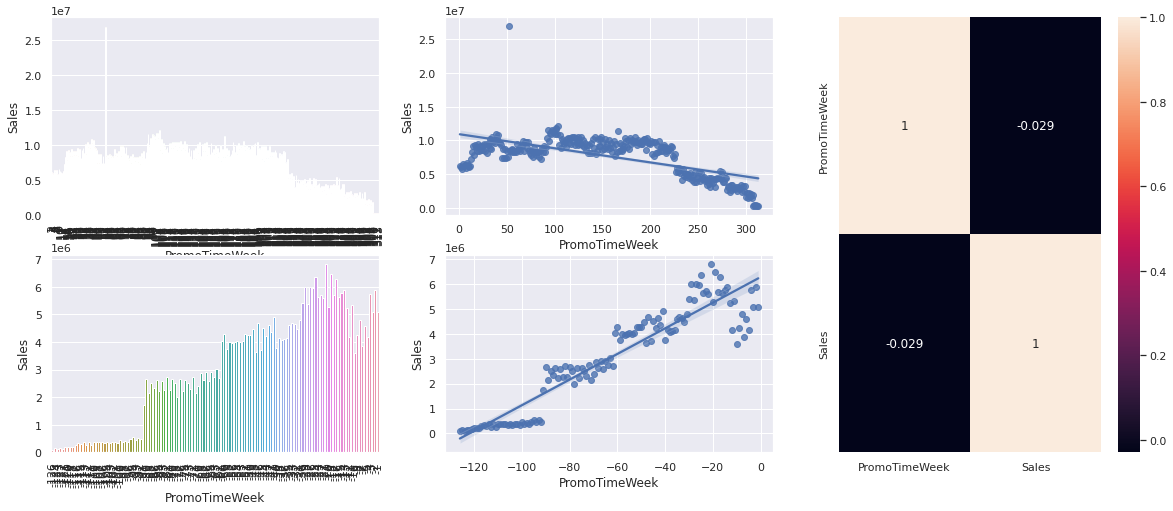

In [ ]:
# two periods of promo: the standard (promo) and the extended (promo 2).
# promo_time_week > 0 means the sale at that date was done in the promo 2 period (extended).
# promo_time_week < 0 means the sale at that date was done in the standard promo period.

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# Grid spec - plot
grid = gridspec.GridSpec( 2, 3)

# sum of sales by promo_time_week
aux4_1 = df_4[['PromoTimeWeek', 'Sales']].groupby( 'PromoTimeWeek' ).sum().reset_index()

# sort the data into extended promo period (promo2).
plt.subplot( grid[0,0] )
aux4_2 = aux4_1[aux4_1['PromoTimeWeek'] > 0] # promo extended (promo 2)
# bar plot
sns.barplot( x='PromoTimeWeek', y='Sales', data=aux4_2 );
# rotate x axis labels
plt.xticks( rotation=90 );

# reg plot to check tendency
plt.subplot( grid[0,1] )
sns.regplot( x='PromoTimeWeek', y='Sales', data=aux4_2 );

# sort the data into standard promo period.
plt.subplot( grid[1,0] )
aux4_3 = aux4_1[aux4_1['PromoTimeWeek'] < 0] # promo standard
# bar plot
sns.barplot( x='PromoTimeWeek', y='Sales', data=aux4_3 );
# rotate x axis labels
plt.xticks( rotation=90 );

# reg plot to check tendency
plt.subplot( grid[1,1] )
sns.regplot( x='PromoTimeWeek', y='Sales', data=aux4_3 );

# Correlation strength - heatmap
plt.subplot( grid[:,2] )
sns.heatmap( aux4_1.corr( method='pearson'), annot=True );

In [ ]:
#H6. Stores with more consecutive Sale (promo) should sell more.
#FALSE Stores with more consecutive Sale sell less.

4.1.5. HYPOTESE 5: STORES WTH CONSECUTIVE SALES PROMOTIONS SELL MORE.

In [ ]:
df_4[['Promo', 'Promo2', 'Sales']].groupby( ['Promo', 'Promo2'] ).sum().reset_index()

,Promo,Promo2,Sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


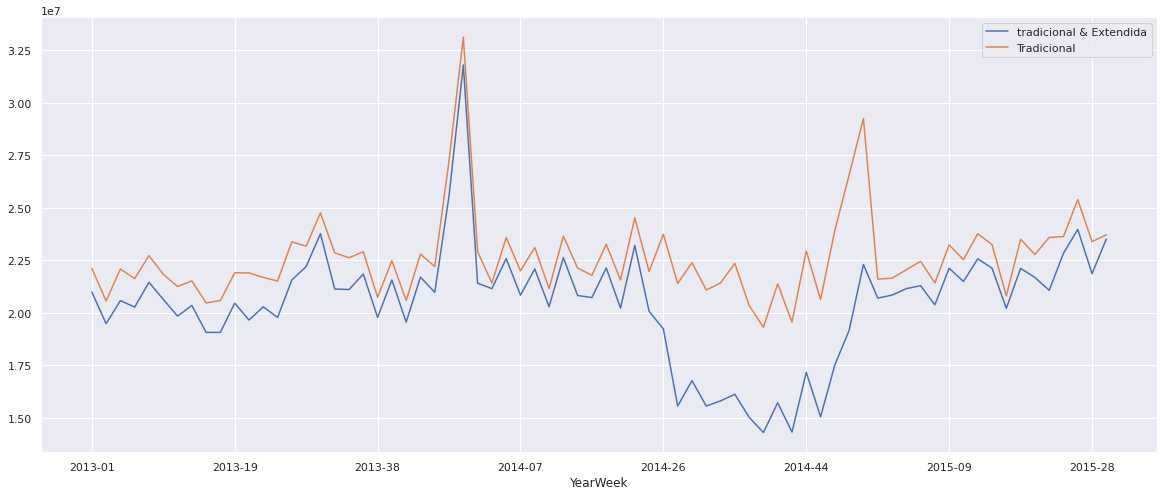

In [ ]:
aux6_1 = df_4[ (df_4['Promo'] == 1) & ( df_4['Promo2'] == 1)][['YearWeek', 'Sales']].groupby( 'YearWeek' ).sum().reset_index()
aux6_1 = aux6_1.set_index('YearWeek')
ax = aux6_1.plot( figsize=(20,8))

aux6_2 = df_4[ (df_4['Promo'] == 1) & ( df_4['Promo2'] == 0)][['YearWeek', 'Sales']].groupby( 'YearWeek' ).sum().reset_index()

aux6_2.plot( ax=ax)

ax.legend( labels=['tradicional & Extendida', 'Tradicional'])

4.1.6. HYPOTESE 5: STORES OPEN ON CHRSTMAS TIME SELL MORE.

TRUE: Stores open on Christmas sell well.


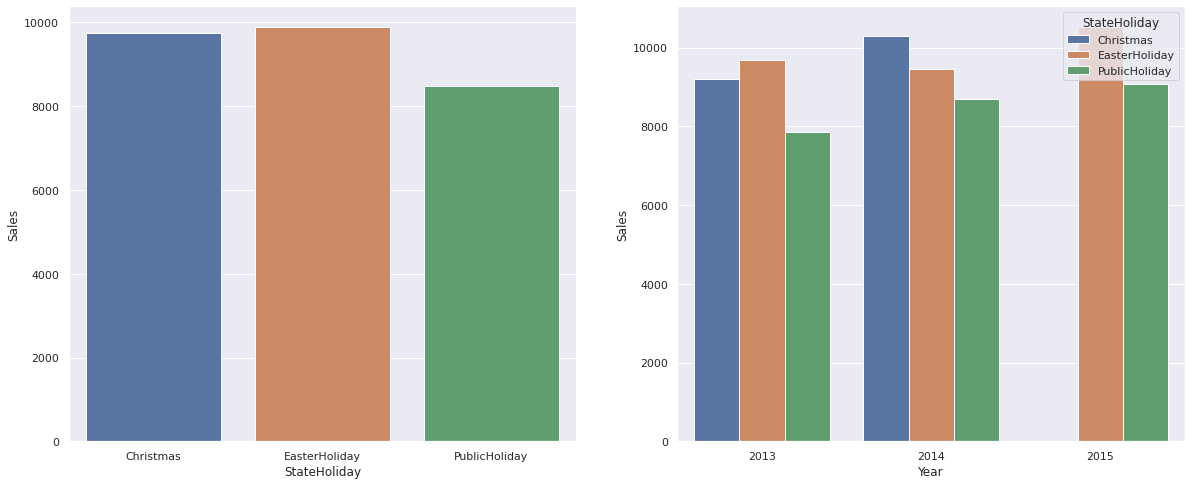

In [ ]:
# filter state_holiday without 'regular_day'
aux = df_4[df_4['StateHoliday'] != 'RegularDay']

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 2, 1)
# sum of sales by state_holiday
aux7_1 = aux[['StateHoliday', 'Sales']].groupby( 'StateHoliday' ).mean().reset_index()
sns.barplot( x='StateHoliday', y='Sales', data=aux7_1);


# set up subplot
plt.subplot( 1, 2, 2)
# sum of sales by state_holiday and year
aux7_2 = aux[['Year', 'StateHoliday', 'Sales']].groupby( ['Year', 'StateHoliday']).mean().reset_index()
sns.barplot( x='Year', y='Sales', hue='StateHoliday', data=aux7_2)

4.1.7. HYPOTESE 7: STORES SELL MORE OVER THE YEARS.

TRUE Stores sell MORE throughout the years.

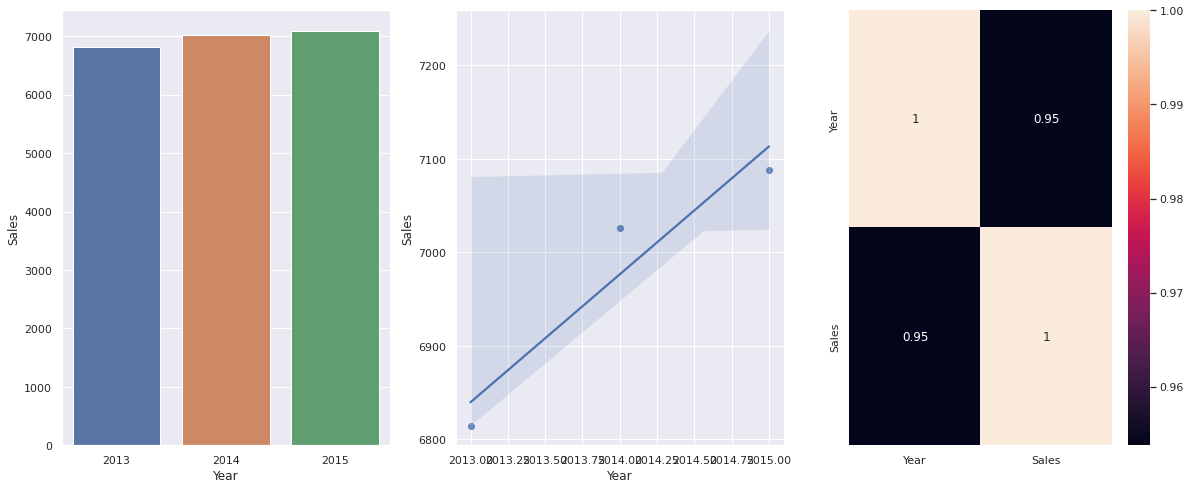

In [ ]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by year
aux8_1 = df_4[['Year', 'Sales']].groupby( 'Year').mean().reset_index()
sns.barplot( x='Year', y='Sales', data=aux8_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='Year', y='Sales', data=aux8_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux8_1.corr( method='pearson'), annot=True);

4.1.8. HYPOTESE 8: STORES SELL MORE ON SECOND SEMESTER.

TRUE Stores sell MORE on second semester.

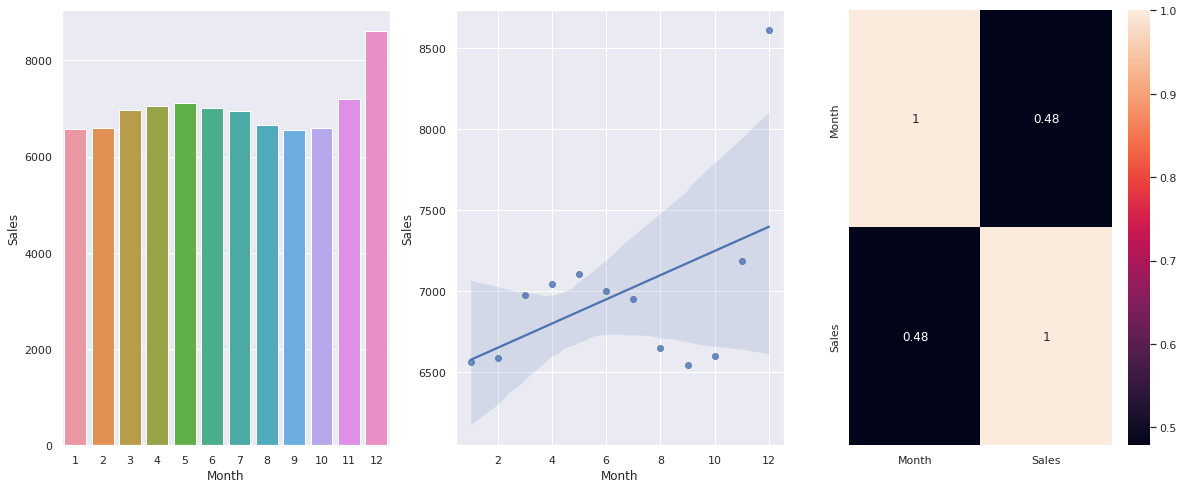

In [ ]:
#set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by month
aux9_1 = df_4[['Month', 'Sales']].groupby( 'Month').mean().reset_index()
sns.barplot( x='Month', y='Sales', data=aux9_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='Month', y='Sales', data=aux9_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux9_1.corr( method='pearson'), annot=True);

4.1.9. HYPOTESE 9: STORES SHOULD SELL MORE AFTER THE 10th DAY OF THE MONTH.

FALSE: Stores sell LESS after the 10th day of the month.

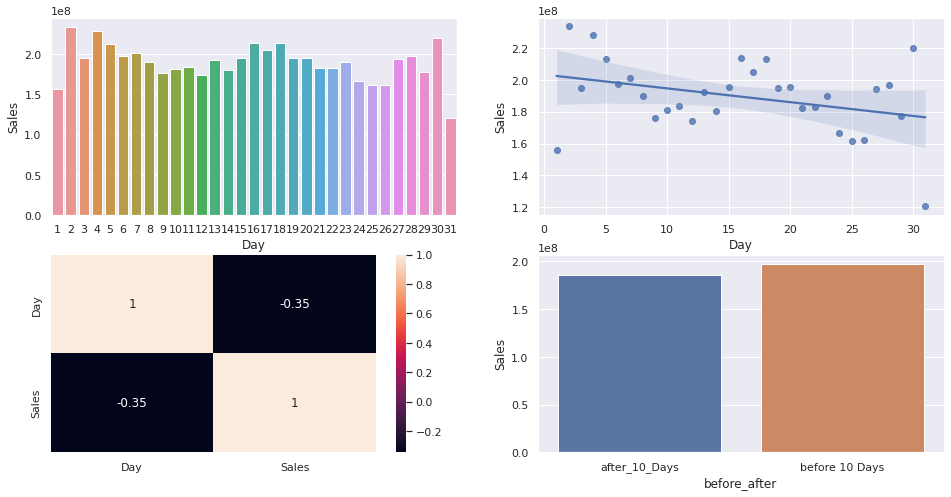

In [ ]:
# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# set up subplot
plt.subplot( 2, 2, 1)
# sum of sales by day
aux10_1 = df_4[['Day', 'Sales']].groupby( 'Day').sum().reset_index()
sns.barplot( x='Day', y='Sales', data=aux10_1 );

# set up subplot
plt.subplot( 2, 2, 2)
# Trend graph
sns.regplot( x='Day', y='Sales', data=aux10_1);

# set up subplot
plt.subplot( 2, 2, 3)
# correlation graph (heatmap)
sns.heatmap( aux10_1.corr( method='pearson'), annot=True);

# set up subplot
plt.subplot( 2, 2, 4)
# filter the days before and after the 10th day of each month
aux10_1['before_after'] = aux10_1['Day'].apply( lambda x: 'before 10 Days' if x <= 10 else 'after_10_Days')
aux10_2 = aux10_1[['before_after', 'Sales']].groupby('before_after').mean().reset_index()
sns.barplot( x='before_after', y='Sales', data=aux10_2)

4.1.10. HYPOTESE 10: STORES SHOULD SELL LESS ON WEEKEND.

TRUE: Stores sell LESS on weekend.

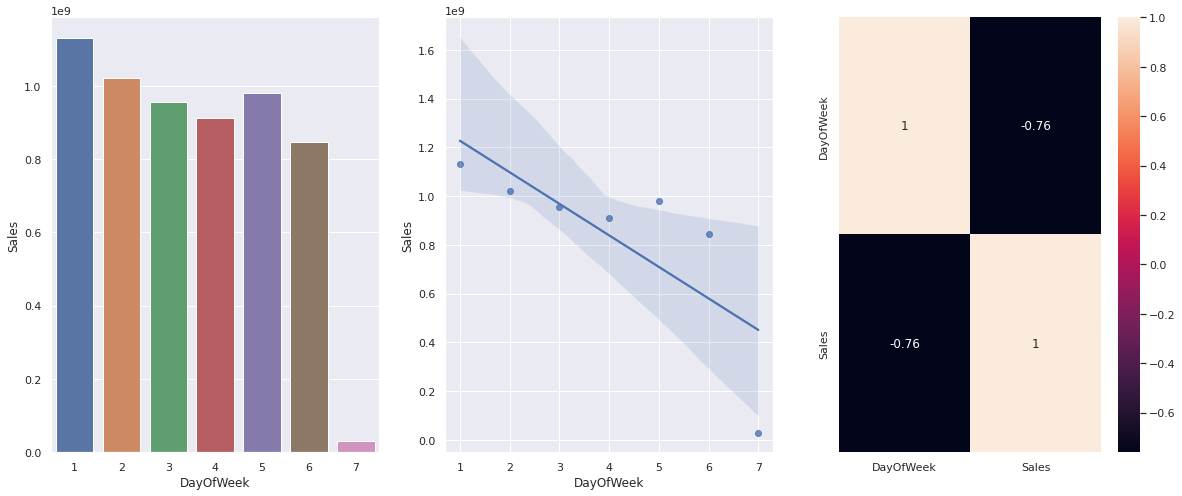

In [ ]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by day_of_week
aux11_1 = df_4[['DayOfWeek', 'Sales']].groupby( 'DayOfWeek').sum().reset_index()
sns.barplot( x='DayOfWeek', y='Sales', data=aux11_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='DayOfWeek', y='Sales', data=aux11_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux11_1.corr( method='pearson'), annot=True);


4.1.11. HYPOTESE 11: STORES SHOULD SELL LESS WHILE SCHOOL VACATION.

FALSE: Stores sell MORE during school vacation, except in december.

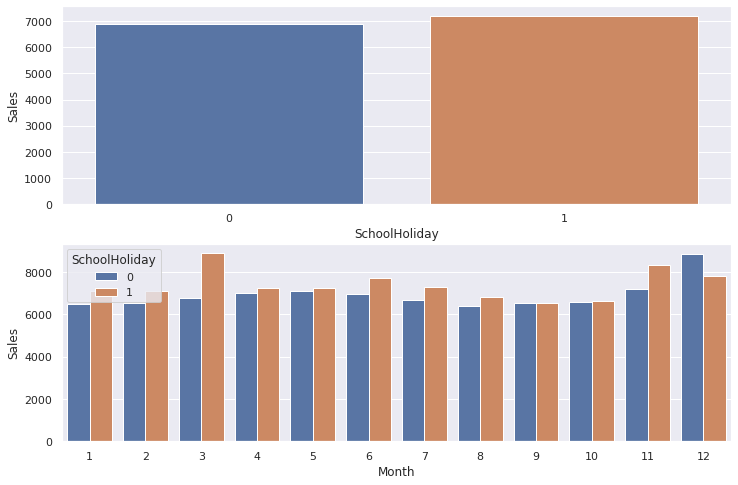

In [ ]:
# set up figure size
f, ax = plt.subplots(figsize=(12,8))

# set up subplot
plt.subplot( 2, 1, 1)
# sum of sales by school_holiday
aux12_1 = df_4[['SchoolHoliday', 'Sales']].groupby( 'SchoolHoliday' ).mean().reset_index()
sns.barplot( x='SchoolHoliday', y='Sales', data=aux12_1);

# set up subplot
plt.subplot( 2, 1, 2)
aux12_2 = df_4[['Month', 'SchoolHoliday', 'Sales']].groupby( ['Month', 'SchoolHoliday'] ).mean().reset_index()
sns.barplot( x='Month', y='Sales', hue='SchoolHoliday', data=aux12_2);

## 4.3. MULTIVARIATE ANALYSIS

#### 4.3.1. NUMERICAL ATTRIBUTES

In [ ]:
correlations = df_4.corr()

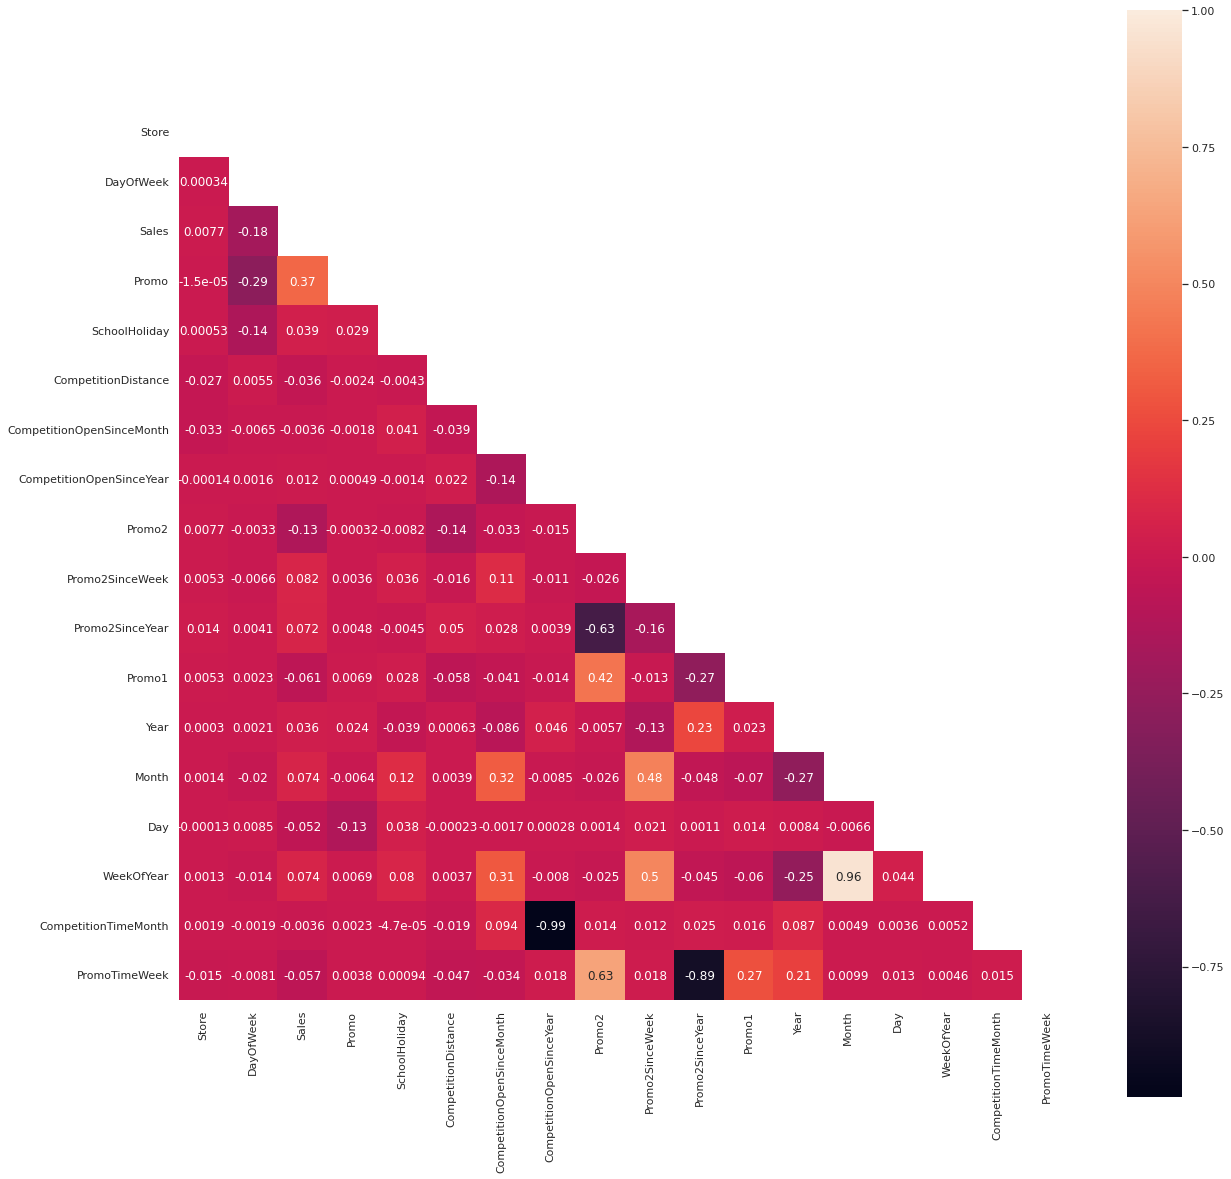

In [ ]:
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(correlations, mask=mask,annot=True,vmax=1, square=True)

#### 4.3.2. CATEGORICAL ATTRIBUTES

In [ ]:
# Select categorical attributes
cat_a = df_4.select_dtypes( include='object' )
cat_a.head()

,StateHoliday,StoreType,Assortment,YearWeek
0,RegularDay,c,basic,2015-30
1,RegularDay,a,basic,2015-30
2,RegularDay,a,basic,2015-30
3,RegularDay,c,extended,2015-30
4,RegularDay,a,basic,2015-30


In [ ]:
# confusion matrix makes all the possible combinations between categorical variables
# and count the number of lines of that combination.
cat_a[(cat_a['StateHoliday'] == 'Christmas' ) & ( cat_a['StoreType'] == 'a' )]

,StateHoliday,StoreType,Assortment,YearWeek
241499,Christmas,a,extended,2014-51
241977,Christmas,a,extended,2014-51
616339,Christmas,a,extended,2013-51
616908,Christmas,a,extended,2013-51


In [ ]:
# chi2 formula
def cramer_v( x, y ):
    # calculate confusion matrix (cm), contingency table
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    # calculate chi2
    chi2 = stats.chi2_contingency( cm )[0]
    # chi2 correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    # k correction
    kcorr = k - (k-1)**2/(n-1)
    # r correction
    rcorr = r - (r-1)**2/(n-1)
    
    # return Cramer V
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

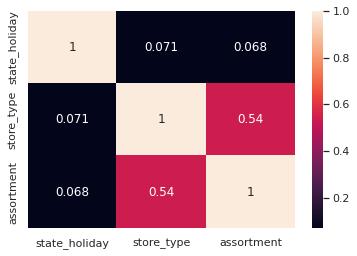

In [ ]:
# calculate Cramer V
# Cramer V (chi2) formula is in the 0.1. Helper Functions subsection.
a1 = cramer_v(cat_a['StateHoliday'], cat_a['StateHoliday'] )
a2 = cramer_v(cat_a['StateHoliday'], cat_a['StoreType'] )
a3 = cramer_v(cat_a['StateHoliday'], cat_a['Assortment'] )

a4 = cramer_v(cat_a['StoreType'], cat_a['StateHoliday'] )
a5 = cramer_v(cat_a['StoreType'], cat_a['StoreType'] )
a6 = cramer_v(cat_a['StoreType'], cat_a['Assortment'] )

a7 = cramer_v(cat_a['Assortment'], cat_a['StateHoliday'] )
a8 = cramer_v(cat_a['Assortment'], cat_a['StoreType'] )
a9 = cramer_v(cat_a['Assortment'], cat_a['Assortment'] )

## final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9] })

d = d.set_index( d.columns)

sns.heatmap( d, annot=True);

# 5.0. DATA PREPARATION

In [ ]:
df_5 = df_4.copy()

In [ ]:
df_5.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Promo,1,1,1,1,1
StateHoliday,RegularDay,RegularDay,RegularDay,RegularDay,RegularDay
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a
Assortment,basic,basic,basic,extended,basic
CompetitionDistance,1270.0,570.0,14130.0,620.0,29910.0


## 5.1. RESCALING

In [ ]:
df_5.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,844338.0,558.421374,321.730861,1.0,280.0,558.0,837.0,1115.0
DayOfWeek,844338.0,3.520350,1.723712,1.0,2.0,3.0,5.0,7.0
Sales,844338.0,6955.959134,3103.815515,46.0,4859.0,6369.0,8360.0,41551.0
Promo,844338.0,0.446356,0.497114,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,844338.0,0.193578,0.395102,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,844338.0,5450.057797,7801.076826,20.0,710.0,2330.0,6880.0,75860.0
CompetitionOpenSinceMonth,844338.0,6.787355,3.309917,1.0,4.0,7.0,10.0,12.0
CompetitionOpenSinceYear,844338.0,2010.331102,5.502628,1900.0,2008.0,2012.0,2014.0,2015.0
Promo2,844338.0,0.498670,0.499999,0.0,0.0,0.0,1.0,1.0
Promo2SinceWeek,844338.0,23.629083,14.288315,1.0,12.0,22.0,37.0,52.0


In [ ]:
import warnings

warnings.filterwarnings('ignore')

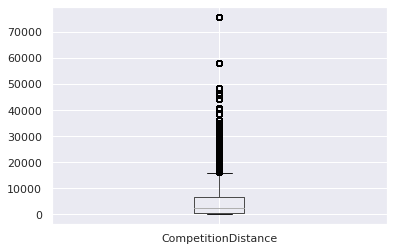

In [ ]:
df_5.boxplot(column=['CompetitionDistance']);

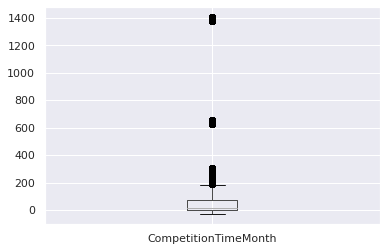

In [ ]:
df_5.boxplot(column=['CompetitionTimeMonth']);

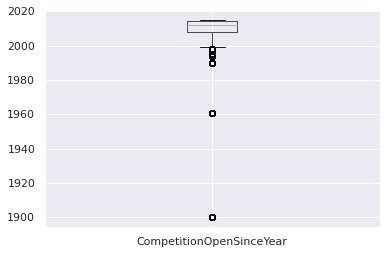

In [ ]:
df_5.boxplot(column=['CompetitionOpenSinceYear']);

#### 5.1.1. DUE TO THE LARGE VOLUME OF OUTLIERS WE WILL USE THE **ROBUST SCALER** ON THE VARIABLES:
1.   CompetitionDistance
1.   CompetitionTimeMonth
2.   CompetitionOpenSinceYear



In [ ]:

robust_s = RobustScaler()
df_5['CompetitionDistance'] = robust_s.fit_transform( df_5[['CompetitionDistance']].values )
df_5['CompetitionTimeMonth'] = robust_s.fit_transform( df_5[['CompetitionTimeMonth']].values )
df_5['CompetitionOpenSinceYear'] = robust_s.fit_transform( df_5[['CompetitionOpenSinceYear']].values )


#### 5.1.2. WE WILL USE THE **MIN-MAX SCALER** DUE TO THE LOW INFLUENCE OF OUTLIERS ON THE VARIABLES:
1.   PromoTimeWeek
2.   Year
3.   Promo2SinceYear

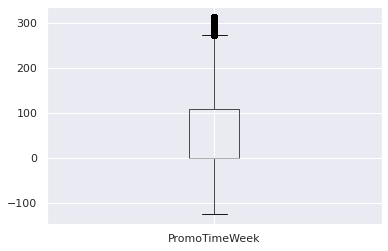

In [ ]:
df_5.boxplot(column=['PromoTimeWeek']);

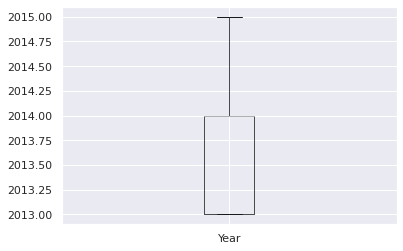

In [ ]:
df_5.boxplot(column=['Year']);

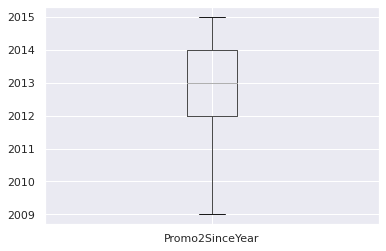

In [ ]:
df_5.boxplot(column=['Promo2SinceYear']);

In [ ]:
minmax_s = MinMaxScaler()
df_5['PromoTimeWeek'] = minmax_s.fit_transform( df_5[['PromoTimeWeek']].values )
df_5['Year'] = minmax_s.fit_transform( df_5[['Year']].values )
df_5['Promo2SinceYear'] = minmax_s.fit_transform( df_5[['Promo2SinceYear']].values )

In [ ]:
df_5[['PromoTimeWeek','Year','Promo2SinceYear']].describe()

,PromoTimeWeek,Year,Promo2SinceYear
count,844338.000000,844338.000000,844338.000000
mean,0.410936,0.415973,0.632986
std,0.194664,0.388636,0.276687
min,0.000000,0.000000,0.000000
25%,0.287016,0.000000,0.500000
50%,0.287016,0.500000,0.666667
75%,0.535308,0.500000,0.833333
max,1.000000,1.000000,1.000000


## 5.2. ENCONDING TRANSFORMATION FEATURES


*   StateHoliday
*   StoreType
*   Assortment





In [ ]:
df_5 = pd.get_dummies(df_5, prefix=['StateHoliday'], columns=['StateHoliday'])                      

In [ ]:
leB = LabelEncoder()
df_5['StoreType'] = leB.fit_transform( df_5['StoreType'])

In [ ]:
d = {'basic':1, 'extra': 2, 'extended': 3}
df_5['Assortment'] = df_5['Assortment'].map(d )

In [ ]:
df_5.head()

,Store,DayOfWeek,Date,Sales,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Promo1,Year,Month,Day,WeekOfYear,YearWeek,CompetitionSince,CompetitionTimeMonth,PromoSince,PromoTimeWeek,StateHoliday_Christmas,StateHoliday_EasterHoliday,StateHoliday_PublicHoliday,StateHoliday_RegularDay
0,1,5,2015-07-31,5263,1,1,2,1,-0.171799,9,-0.666667,0,31,1.000000,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.285251,11,-0.833333,1,13,0.166667,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.912480,12,-1.000000,1,14,0.333333,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.277147,9,-0.500000,0,31,1.000000,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.470016,4,0.500000,0,31,1.000000,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


## 5.3. NATURE TRANSFORMATION: CYCLIC VARIABLES

*   DayOfWeek
*   Day
*   Month
*   WeekOfYear



In [ ]:
df_5['DayOfWeek_sin'] = df_5['DayOfWeek'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df_5['DayOfWeek_cos'] = df_5['DayOfWeek'].apply( lambda x: np.cos( x * (2. * np.pi/7) ) )

df_5['Day_sin'] = df_5['Day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df_5['Day_cos'] = df_5['Day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

df_5['Month_sin'] = df_5['Month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df_5['Month_cos'] = df_5['Month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

df_5['WeekOfYear_sin'] = df_5['WeekOfYear'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df_5['WeekOfYear_cos'] = df_5['WeekOfYear'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

## 5.4. TARGET TRANSFORMATION

In [ ]:
df_5['Sales'] = np.log1p( df_5['Sales'] )

# 6.0. FEATURE SELECTION

In [ ]:
df_5a = df_5.sample(150000)
df_5a

,Store,DayOfWeek,Date,Sales,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Promo1,Year,Month,Day,WeekOfYear,YearWeek,CompetitionSince,CompetitionTimeMonth,PromoSince,PromoTimeWeek,StateHoliday_Christmas,StateHoliday_EasterHoliday,StateHoliday_PublicHoliday,StateHoliday_RegularDay,DayOfWeek_sin,DayOfWeek_cos,Day_sin,Day_cos,Month_sin,Month_cos,WeekOfYear_sin,WeekOfYear_cos
314113,158,4,2014-10-09,8.943898,1,0,3,3,1.541329,10,0.333333,1,31,0.000000,0,0.5,10,9,41,2014-40,2014-10-01,-0.216216,2009-07-27,0.904328,0,0,0,1,-0.433884,-0.900969,0.951057,-0.309017,-8.660254e-01,5.000000e-01,-0.970942,0.239316
639170,1061,5,2013-12-06,8.919186,1,0,3,3,0.936791,12,0.166667,0,49,0.666667,0,0.0,12,6,49,2013-48,2013-12-01,-0.216216,2013-12-02,0.287016,0,0,0,1,-0.974928,-0.222521,0.951057,0.309017,-2.449294e-16,1.000000e+00,-0.354605,0.935016
972661,52,6,2013-02-09,8.787526,0,0,3,3,-0.304700,4,0.333333,1,39,0.166667,0,0.0,2,9,6,2013-05,2014-04-01,-0.405405,2010-09-20,0.569476,0,0,0,1,-0.781831,0.623490,0.951057,-0.309017,8.660254e-01,5.000000e-01,0.663123,0.748511
507653,1114,4,2014-04-03,9.951516,1,0,0,3,-0.236629,4,0.333333,0,14,0.833333,0,0.5,4,3,14,2014-13,2014-04-01,-0.216216,2014-03-31,0.287016,0,0,0,1,-0.433884,-0.900969,0.587785,0.809017,8.660254e-01,-5.000000e-01,0.992709,-0.120537
710967,383,3,2013-10-02,9.773720,0,0,0,3,-0.320908,10,0.166667,0,40,0.666667,0,0.0,10,2,40,2013-39,2013-10-01,-0.216216,2013-09-30,0.287016,0,0,0,1,0.433884,-0.900969,0.406737,0.913545,-8.660254e-01,5.000000e-01,-0.992709,0.120537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723645,796,6,2013-09-21,8.244071,0,0,0,3,0.786062,11,0.000000,0,38,0.666667,0,0.0,9,21,38,2013-37,2012-11-01,-0.081081,2013-09-16,0.287016,0,0,0,1,-0.781831,0.623490,-0.951057,-0.309017,-1.000000e+00,-1.836970e-16,-0.992709,-0.120537
296860,770,2,2014-10-28,8.540910,0,0,0,3,-0.361426,4,0.500000,0,44,0.833333,0,0.5,10,28,44,2014-43,2015-04-01,-0.297297,2014-10-27,0.287016,0,0,0,1,0.974928,-0.222521,-0.406737,0.913545,-8.660254e-01,5.000000e-01,-0.822984,0.568065
606720,946,6,2014-01-04,7.788626,0,0,0,1,-0.017828,12,-0.166667,1,14,1.000000,1,0.5,1,4,1,2014-00,2011-12-01,0.121622,2015-03-30,0.138952,0,0,0,1,-0.781831,0.623490,0.743145,0.669131,5.000000e-01,8.660254e-01,0.120537,0.992709
686644,590,4,2013-10-24,8.380457,1,0,3,3,0.354943,9,-0.333333,1,31,0.666667,1,0.0,10,24,43,2013-42,2010-09-01,0.297297,2013-07-29,0.314351,0,0,0,1,-0.433884,-0.900969,-0.951057,0.309017,-8.660254e-01,5.000000e-01,-0.885456,0.464723


In [ ]:
df_6 = df_5a.copy()

## 6.1. SPLIT DATAFRAME INTO TRAINING AND TEST DATRASETES

####  6.1.1. REMOVE COLUMNS THAT DERIVED NEW FEATURES


In [ ]:
cols_drop = ['WeekOfYear', 'Day', 'Month', 'DayOfWeek', 'PromoSince', 'CompetitionSince', 'YearWeek']
df_6 = df_6.drop( cols_drop, axis=1 )

####  6.1.2. SELECT THE DATE THE LAST 6 WEEKS FOR THE TEST DATASET

In [ ]:
df_6[['Store', 'Date']].groupby( 'Store' ).max().reset_index()['Date'][0] - timedelta( days=6*7 )

Timestamp('2015-06-12 00:00:00')

####  6.1.3. TRAIN DATASET WITH ENTRIES BEFORE THE LAST 6 WEEKS

In [ ]:
X_train = df_6[df_6['Date'] < '2015-06-19']
y_train = X_train['Sales']

In [ ]:
print(f'Training Max Date: { X_train["Date"].max()}')

Training Max Date: 2015-06-18 00:00:00


In [ ]:
print(f'Train Min Date: {X_train["Date"].min()}' )
print( f'Train Max Date: {X_train["Date"].max()}' )

Train Min Date: 2013-01-01 00:00:00
Train Max Date: 2015-06-18 00:00:00


####  6.1.4. TEST DATASET WITH ENTRIES FROM THE LAST 6 WEEKS 

In [ ]:
X_test = df_6[df_6['Date'] >= '2015-06-19']
y_test = X_test['Sales']

In [ ]:
print( f'Test Min Date: {X_test["Date"].min()}') 
print( f'Test Max Date: {X_train["Date"].max()}')

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-06-18 00:00:00


## 6.2. SELECT VARIABLES WITH BORUTA

#### 6.2.1. CONVERT FROM PANDAS FORMAT TO NUMPY VALUES TO RUN BORUTA

In [ ]:
x_train_n = X_train.drop( ['Date', 'Sales'], axis=1 ).values

In [ ]:
y_train_n = y_train.values.ravel()

In [ ]:
rfr = RandomForestRegressor( n_jobs=-1 )

In [ ]:
boruta = BorutaPy( rfr, n_estimators='auto', verbose=2, random_state=2 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


#### 6.2.2. FEATURES SELECTED BY BORUTA

In [ ]:
fea_selected = boruta.support_.tolist()

x_train_fs = X_train.drop( ['Date', 'Sales'], axis=1 )

fea_selected_boruta = x_train_fs.iloc[:, fea_selected].columns.to_list()

fea_selected_boruta

['Store',
 'Promo',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'CompetitionTimeMonth',
 'PromoTimeWeek',
 'DayOfWeek_sin',
 'DayOfWeek_cos',
 'Day_sin',
 'Day_cos',
 'Month_cos']

#### 6.2.3. FEATURES REJECTED BY BORUTA

In [ ]:
fea_not_selected_boruta = list( np.setdiff1d ( x_train_fs.columns, fea_selected_boruta ))

fea_not_selected_boruta

['Month_sin',
 'Promo1',
 'SchoolHoliday',
 'StateHoliday_Christmas',
 'StateHoliday_EasterHoliday',
 'StateHoliday_PublicHoliday',
 'StateHoliday_RegularDay',
 'WeekOfYear_cos',
 'WeekOfYear_sin',
 'Year']

#### 6.2.4. SELECTED FEATURES

##### ADDED Month_sin and WeekOfYear_sin 

In [ ]:
  featuries_selected = ['Store',
                        'Promo',
                        'StoreType',
                        'Assortment',
                        'CompetitionDistance',
                        'CompetitionOpenSinceMonth',
                        'CompetitionOpenSinceYear',
                        'Promo2',
                        'Promo2SinceWeek',
                        'Promo2SinceYear',
                        'CompetitionTimeMonth',
                        'PromoTimeWeek',
                        'Month_sin',
                        'Month_cos',
                        'Day_sin',
                        'Day_cos',
                        'WeekOfYear_sin',
                        'WeekOfYear_cos',
                        'DayOfWeek_sin',
                        'DayOfWeek_cos']

#### 6.2.5. REINTRODUCE DATE AND SALES VARIABLES

In [ ]:
reint_var = ['Date','Sales']

featuries_selected.extend( reint_var )

In [ ]:
# Select boruta columns with date and sales. It will be applied on cross-validation step.
fea_selected_boruta_full = fea_selected_boruta.copy()
fea_selected_boruta_full.extend( reint_var )

# 7.0. MODEL TRAINING

#### 7.0.1 FEATURES SELECTED BY BORUTA

In [ ]:
x_train = X_train[ fea_selected_boruta ]
x_test = X_test[ fea_selected_boruta ]

#### 7.0.2 THE DATE AND SALES FEATURES WILL BE ADDED LATER

In [ ]:
x_training = X_train[ fea_selected_boruta_full ]

## 7.1. AVERAGE MODEL

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### 7.1.1 FUNCTION ML ERROR MEAN ABSOLUTE PERCENTAGE ERROR

In [ ]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y - yhat ) / y) )

#### 7.1.2 ERROR SUMMARY FUNCTION ML APPLIED

In [ ]:
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE' : rmse}, index=[0])


#### 7.1.3. aux1 VARIABLE FOR CALCULATION

In [ ]:
aux1 = x_test.copy()
aux1['Sales'] = y_test.copy()

#### 7.1.4. PREDICTIONS VARIABLE = AVERAGE SALES PER STORES

In [ ]:
aux2 = aux1[['Store', 'Sales']].groupby( 'Store' ).mean().reset_index().rename( columns={'Sales' : 'Predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='Store' )
yhat_baseline = aux1['Predictions']

#### 7.1.5. PERFORMANCE

In [ ]:
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1( yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1274.143251,0.404633,1738.169635


## 7.2. LINEAR REGRESSION MODEL

In [ ]:
lr = LinearRegression().fit( x_train, y_train )

#### 7.2.1. PREDICTION AND PERFORMANCE

In [ ]:
yhat_lr = lr.predict( x_test )

lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1( yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1888.8779,0.296262,2682.730654


#### 7.2.2. CROSS VALIDATION - LINEAR REGRESSION 

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []

    # Cross-validation k-fold
    # k-fold range. reversed: range from max to min.
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        # start and end date for validation
        # subtract 6 weeks (6*7) from date max: first date of validation
        validation_start_date = x_training['Date'].max() - timedelta( days=k*6*7 )
        validation_end_date = x_training['Date'].max() - timedelta( days=(k-1)*6*7 )

        # filtering dataset for training and validation
        training = x_training[x_training['Date'] < validation_start_date]
        validation = x_training[(x_training['Date'] >= validation_start_date) & (x_training['Date'] <= validation_end_date)]

        # training dataset
        xtraining = training.drop( ['Date', 'Sales'], axis=1 )
        ytraining = training['Sales']

        # validation dataset
        xvalidation = validation.drop( ['Date', 'Sales'], axis=1 )
        yvalidation = validation['Sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
    
        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
        # mean and standard deviation of errors after cross-validation
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE CV': np.round( np.mean( mae_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list), 2 ).astype( str ),
                           'MAPE CV': np.round( np.mean( mape_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list), 2 ).astype( str ),
                           'RMSE CV': np.round( np.mean( rmse_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list), 2 ).astype( str ) }, index=[0] )

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2073.16 +/- 317.53,0.3 +/- 0.02,2952.89 +/- 488.65


## 7.3. LASSO - LINEAR REGRESSION REGULARIZED MODEL

In [ ]:
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

yhat_lrr = lrr.predict( x_test )

lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1905.004003,0.285896,2774.239839


Linear Regression regularized model (Lasso) RMSE value was higher than standard linear regression. Conclusion: the phenomenon that we measure it is not linear. It is also no simple, therefore a complex model.

#### 7.3.1. LASSO - CROSS VALIDATION

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2112.39 +/- 351.03,0.29 +/- 0.02,3053.13 +/- 511.45


## 7.4. RANDOM FOREST REGRESSOR

In [ ]:
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=2 ).fit( x_train, y_train )

yhat_rf = rf.predict( x_test )

rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,775.574286,0.115058,1105.623728


#### 7.4.1. RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1003.04 +/- 389.98,0.14 +/- 0.05,1483.58 +/- 595.28


## 7.5. XGBOOST REGRESSOR

In [ ]:
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

yhat_xgb = model_xgb.predict( x_test )

xgb_result = ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,939.122735,0.137845,1371.003091


#### 7.5.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1082.2 +/- 189.09,0.15 +/- 0.02,1575.37 +/- 260.93


## 7.6. PERFORMANCE OF MODELS

#### 7.6.1. HOLDOUT MODELS PERFORMANCE

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,775.574286,0.115058,1105.623728
0,XGBoost Regressor,939.122735,0.137845,1371.003091
0,Average Model,1274.143251,0.404633,1738.169635
0,Linear Regression,1888.877900,0.296262,2682.730654
0,Linear Regression - Lasso,1905.004003,0.285896,2774.239839


#### 7.6.2. CROSS VALIDATION MODELS PERFORMANCE

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2073.16 +/- 317.53,0.3 +/- 0.02,2952.89 +/- 488.65
0,Lasso,2112.39 +/- 351.03,0.29 +/- 0.02,3053.13 +/- 511.45
0,Random Forest Regressor,1003.04 +/- 389.98,0.14 +/- 0.05,1483.58 +/- 595.28
0,XGBoost Regressor,1082.2 +/- 189.09,0.15 +/- 0.02,1575.37 +/- 260.93


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. RANDON SEARCH

In [ ]:
import random
import warnings
warnings.filterwarnings( 'ignore' )

In [ ]:
param = {
    'n_estimators': [1500, 2000, 2500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytee': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 3

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() } # return values from param dictionary
    print( hp )
    
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytee'],
                                  min_child_weight=hp['min_child_weight'] )

    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1002.43 +/- 150.2,0.14 +/- 0.02,1409.01 +/- 217.64
0,XGBoost Regressor,1029.76 +/- 142.44,0.15 +/- 0.02,1463.3 +/- 196.56
0,XGBoost Regressor,996.92 +/- 138.39,0.14 +/- 0.02,1424.84 +/- 200.85


## 8.2. FINAL MODEL

In [ ]:
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 15}

{'colsample_bytee': 0.9,
 'eta': 0.01,
 'max_depth': 5,
 'min_child_weight': 15,
 'n_estimators': 1500,
 'subsample': 0.1}

In [ ]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.01,
    'max_depth': 5,
    'subsample': 0.1,
    'colsample_bytee': 0.9,
    'min_child_weight': 15
        }

In [ ]:
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,836.26157,0.125946,1172.078034


In [ ]:
import pickle

In [ ]:
with open( '/gdrive/MyDrive/RossmannStoreSales/model_xgb_rossmann.pkl', 'wb' ) as f:
    pickle.dump(model_xgb_tuned, f)

# 9.0. ERROR TRANSLATION AND INTERPRETATION

In [ ]:
df9 = X_test[ fea_selected_boruta_full ]

df9['Sales'] = np.expm1( df9['Sales'] )
df9['Predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. BUSINESS PERFORMANCE

In [ ]:
# SUM OF PREDICTIONS
df91 = df9[['Store', 'Predictions']].groupby('Store').sum().reset_index()

# MAE(MEAN ABSOLUTE ERROR) AND MAPE(MEAN ABSOLUTE PERCENTAGE ERROR)
df9_aux1 = df9[['Store', 'Sales', 'Predictions']].groupby('Store').apply(lambda x: mean_absolute_error( x['Sales'], x['Predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['Store', 'Sales', 'Predictions']].groupby('Store').apply(lambda x: mean_absolute_percentage_error( x['Sales'], x['Predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# MERGE
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='Store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='Store' )

# SCENARIOS
df92['WorstScenario'] = df92['Predictions'] - df92['MAE']
df92['BestScenario'] = df92['Predictions'] + df92['MAE']

# COLUMNS
df92 = df92[['Store', 'Predictions', 'WorstScenario', 'BestScenario', 'MAE', 'MAPE']]

In [ ]:
# SORT STORES WITH HIGHER MAPE
df92.sort_values( 'MAPE', ascending=False ).head()

,Store,Predictions,WorstScenario,BestScenario,MAE,MAPE
481,483,11086.914062,9674.609212,12499.218913,1412.304850,0.843615
779,782,48420.195312,47141.464844,49698.925781,1278.730469,0.538399
906,909,39040.386719,31038.663867,47042.109570,8001.722852,0.481556
1108,1111,26121.978516,24393.666870,27850.290161,1728.311646,0.440118
825,828,25358.539062,24058.445605,26658.632520,1300.093457,0.434996


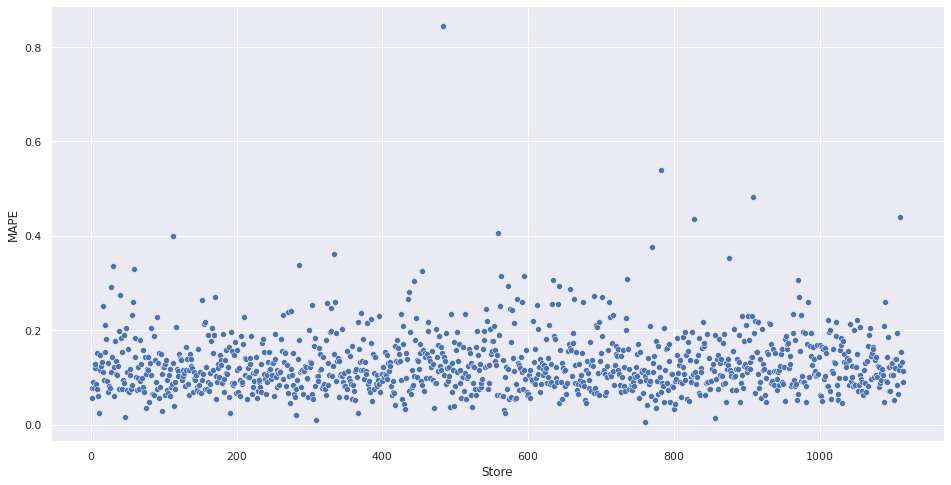

In [ ]:
f, ax = plt.subplots( figsize=(16,8))
sns.scatterplot( x='Store', y='MAPE', data=df92);

In [ ]:
df92.sample(4)

,Store,Predictions,WorstScenario,BestScenario,MAE,MAPE
156,157,84957.593750,84286.561361,85628.626139,671.032389,0.074442
15,16,36757.250000,35815.578418,37698.921582,941.671582,0.110735
945,948,37232.484375,36477.781055,37987.187695,754.703320,0.091132
653,656,10089.453125,9507.860514,10671.045736,581.592611,0.170810


## 9.2. TOTAL PERFORMANCE

In [ ]:
# sum of values from all stores
df93 = df92[['Predictions', 'WorstScenario', 'BestScenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('€$ {:,.2f}'.format)
df93

,Scenarios,Values
0,Predictions,"€$ 51,795,412.00"
1,WorstScenario,"€$ 50,857,093.74"
2,BestScenario,"€$ 52,733,732.14"


## 9.3. MACHINE LEARNING PERFORMANCE

In [ ]:
# error
df9['error'] = df9['Sales'] - df9['Predictions']

#error rate
df9['error_rate'] = df9['Predictions'] / df9['Sales']

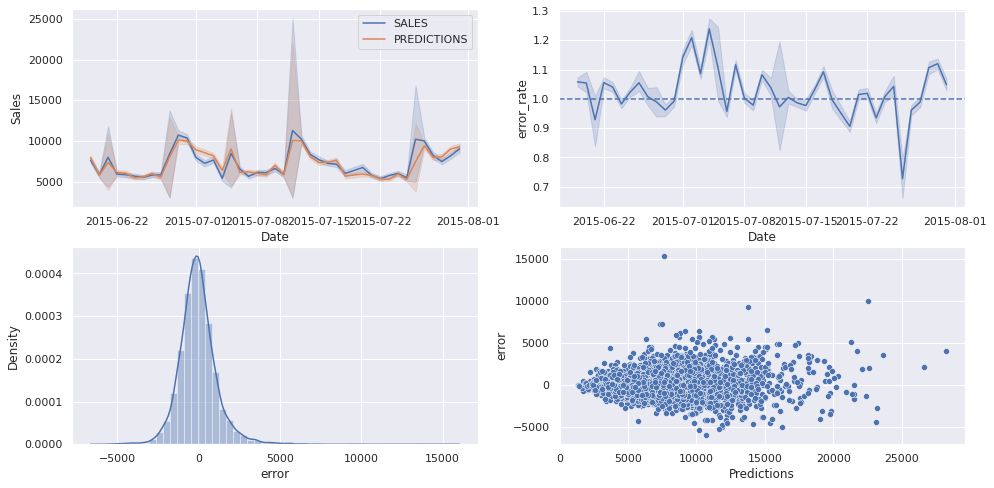

In [ ]:
# set up figure size
f, ax = plt.subplots( figsize=(16,8))

# lineplot date x sales x predictions
plt.subplot( 2, 2, 1 )
sns.lineplot( x='Date', y='Sales', data=df9, label='SALES' )
sns.lineplot( x='Date', y='Predictions', data=df9, label='PREDICTIONS' )

# lineplot date x error_rate
plt.subplot( 2, 2, 2 )
sns.lineplot( x='Date', y='error_rate', data=df9 )
# add line in the lineplot
plt.axhline( 1, linestyle='--')

# plot error distribution
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

# scatter plot predictions x error
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['Predictions'], df9['error'] );

## 9.4. SORT MAPE

In [ ]:
# sort stores with higher MAPE
df92.sort_values( 'MAPE', ascending=False ).head()

,Store,Predictions,WorstScenario,BestScenario,MAE,MAPE
481,483,11086.914062,9674.609212,12499.218913,1412.304850,0.843615
779,782,48420.195312,47141.464844,49698.925781,1278.730469,0.538399
906,909,39040.386719,31038.663867,47042.109570,8001.722852,0.481556
1108,1111,26121.978516,24393.666870,27850.290161,1728.311646,0.440118
825,828,25358.539062,24058.445605,26658.632520,1300.093457,0.434996


In [ ]:
# sort stores with lower MAPE
df92.sort_values( 'MAPE', ascending=True ).head()

,Store,Predictions,WorstScenario,BestScenario,MAE,MAPE
757,760,7701.562988,7652.000000,7751.125977,49.562988,0.006477
307,309,8592.830078,8516.000000,8669.660156,76.830078,0.009022
853,856,21249.583984,21156.033691,21343.134277,93.550293,0.014964
46,47,6454.174805,6347.000000,6561.349609,107.174805,0.016886
280,281,24938.421875,24804.027588,25072.816162,134.394287,0.020244


In [ ]:
# sum of all sales by store and by date
aux2 = df9[['Date', 'Store', 'Sales', 'Predictions']].groupby( ['Date', 'Store'] ).sum().reset_index()
aux2

,Date,Store,Sales,Predictions
0,2015-06-19,3,8074.0,8200.759766
1,2015-06-19,4,9686.0,9656.640625
2,2015-06-19,18,8270.0,8227.993164
3,2015-06-19,31,5881.0,6727.162598
4,2015-06-19,33,8165.0,9655.536133
...,...,...,...,...
7317,2015-07-31,1085,9512.0,9170.320312
7318,2015-07-31,1097,11443.0,11366.799805
7319,2015-07-31,1099,12074.0,10895.199219
7320,2015-07-31,1103,8628.0,8377.829102


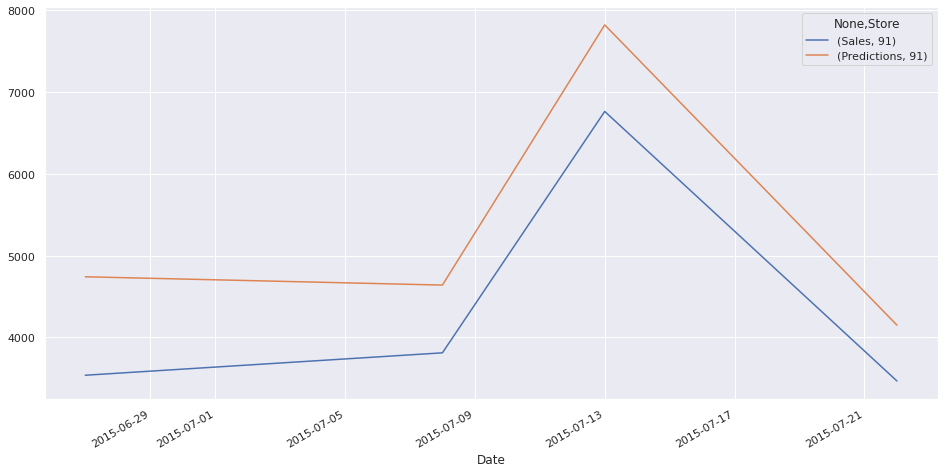

In [ ]:
# lineplot store 1089 - best prediction
aux4 = aux2[aux2['Store'] == 91]
aux4.pivot( index='Date', columns='Store', values=['Sales', 'Predictions']).plot(figsize=(16,8))

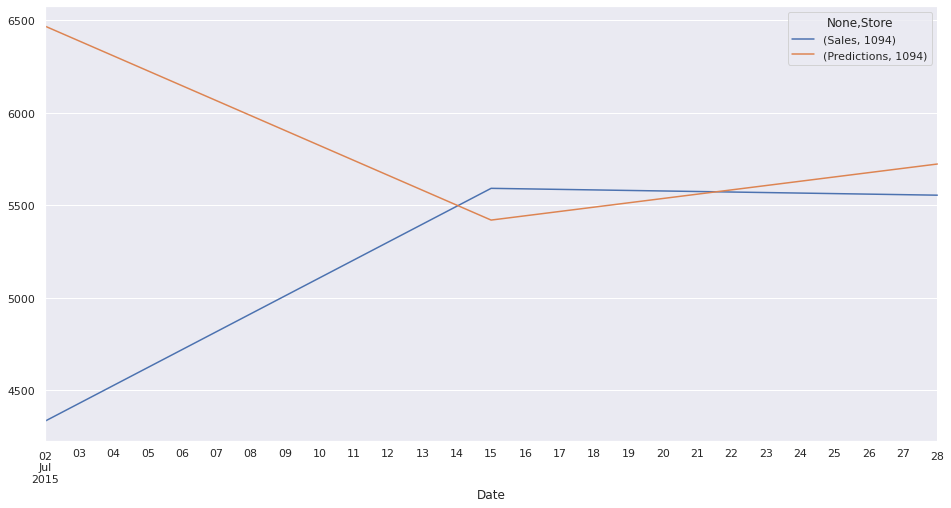

In [ ]:
# lineplot store 1094 - worst prediction
aux5 = aux2[aux2['Store'] == 1094]
aux5.pivot( index='Date', columns='Store', values=['Sales', 'Predictions']).plot(figsize=(16,8));

# 10.0. DEPLOY MODEL TO PRODUCTION - ROSSMANN CLASS

In [ ]:
import pickle
import pandas as pd
import numpy as np
import math
from datetime import datetime
from datetime import timedelta

class Rossmann( object ):
    def __init__( self ):
        self.competition_distance_scaler   = pickle.load( open( '/gdrive/MyDrive/RossmannStoreSales/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( '/gdrive/MyDrive/RossmannStoreSales/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( '/gdrive/MyDrive/RossmannStoreSales/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( '/gdrive/MyDrive/RossmannStoreSales/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( '/gdrive/MyDrive/RossmannStoreSales/store_type_scaler.pkl', 'rb' ) )
    
    def data_cleaning( self, df1 ):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        # Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance
        # market analysis assumption: position without values means a far competition distance, higher than the
        # maximum value from the raw data.
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        # Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
        # over time the sales performance.
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        # Same assumption as competition_open_since_month
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        # Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        # Same assumption as promo2_since_week
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        # Dictionary for Months
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

        # Fill NA values with zero.
        df1['promo_interval'].fillna(0, inplace=True)

        # Add new column with month information
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        # New column that shows if at that date the store was in promo2.
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6. Change Types

        # change competition_open_since_month type to int
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

        # change competition_open_since_year type to int
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        # change promo2_since_week type to int
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

        # change promo2_since_year type to int
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1

    
    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        # Bring together competition_open_since_month and competition_open_since_year
        # Assumption: day = 1 in order to consider the full month.
        df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

        # Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        # 1. Create a string 'year-week'
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        # 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
        # 3. create promo_time_week column with the difference between date and promo_since in weeks.
        # df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. STEP 03 - VARIABLES FILTERING

        ## 3.1. Line Filtering
        # closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
        # sales = 0 will also be removed.
        df2 = df2[df2['open'] != 0]

        ## 3.2. Columns Selection

        # Customers is a variable that is not available at the time of prediction, hence it is a business restriction.
        # To use Customers variable, a new project is needed only for customers forecast in the next 6 weeks, and then use it as input in this sales forecast project.
        # Therefore, the column customers must be removed.
        # open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
        # promo_interval generated new columns in the feature engineering step and is no longer needed.
        # month_map is an auxiliary column and hence will be removed.
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition_time_month
        # Apply RobustScaler due to the presence of outliers.
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
       
        # promo_time_week
        # The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year - apply MinMaxScaler
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )


        ### 5.3.1. Encoding

        # state_holiday - apply one-hot encoding with get_dummies from pandas
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - apply label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - apply ordinal encoding
        # dictionary does not need to be pickled because dictionary can be created in deploy.
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation

        # Tranformation application: Cyclic Nature Transformation with sin and cos
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance',
                                 'competition_open_since_month', 'competition_open_since_year', 'promo2','promo2_since_week',
                                 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_sin','month_cos',
                                 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin',
                                 'day_of_week_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['Prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.1. API HANDLER

In [ ]:
# import pickle
import pickle
# import pandas
import pandas as pd
# import flask
from flask import Flask, request, Response
#import Rossmann class
from rossmann.Rossmann import Rossmann

# load model
model = pickle.load( open( '/gdrive/MyDrive/RossmannStoreSales/model_xgb_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

# create endpoint (URL)
# Post method = send data in order to receive data.
@app.route( '/rossmann/predict', methods=['POST'] )
# function to get the received data
def rossmann_predict():
    test_json = request.get_json()
    
    #check received data (json)
    if test_json: # there is data
        if isinstance( test_json, dict): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else: # there is no data
        return Response( '{}', status=200, mimetype='application/json' )

# check main function in the script
if __name__ == '__main__':
    app.run( '127.0.0.1' ) # local host
---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
<ipython-input-30-1c8d61f34a0e> in <module>
      6 from flask import Flask, request, Response
      7 #import Rossmann class
----> 8 from rossmann.Rossmann import Rossmann
      9 
     10 # load model

ModuleNotFoundError: No module named 'rossmann'

SyntaxError: ignored

## 10.2. API TESTER

In [ ]:
import requests

In [ ]:
# load test dataset
df10 = pd.read_csv('/gdrive/MyDrive/RossmannStoreSales/test.csv')

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
# url = 'http://127.0.0.1:5000/rossmann/predict' # url local
url = 'https://rossmann-model.herokuapp.com/rossmann/predict' # endpoint heroku
header = {'Content-type': 'application/json'}
data = data

# requests = send requsition to endpoint with data.
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format(r.status_code ) )

In [ ]:
# convert back to data frame
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())
d1.head()

In [ ]:
# sum prediction
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

# test for other stores
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R$ {:,.2f} in the next 6 weeks.'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

In [ ]:
data

## 10.3. Rossmann_v02.py Tester

In [ ]:
df1 = df_test.copy()


#### 10.4.1. Data Cleaning df1

In [ ]:
## 1.1. Rename Columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
           'SchoolHoliday', 'Customers', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.3. Data Types
df1['date'] = pd.to_datetime( df1['date'] )

## 1.5. Fillout NA
#competition_distance
# market analysis assumption: position without values means a far competition distance, higher than the
# maximum value from the raw data.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
# over time the sales performance.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
# Same assumption as competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
# Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
# Same assumption as promo2_since_week
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        
# Fill NA values with zero.
df1['promo_interval'].fillna(0, inplace=True)

## 1.6. Change Types

# change competition_open_since_month type to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

# change competition_open_since_year type to int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

# change promo2_since_week type to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

# change promo2_since_year type to int
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
# change customers type to int
df1['customers'] = df1['customers'].astype('int64')

In [ ]:
df1.head()

#### 10.4.2. Feature Engineering df2

In [ ]:
df2 = df1.copy()

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
# Bring together competition_open_since_month and competition_open_since_year
# Assumption: day = 1 in order to consider the full month.
df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

# Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
# 1. Create a string 'year-week'
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
# 3. create promo_time_week column with the difference between date and promo_since in weeks.
# df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. STEP 03 - VARIABLES FILTERING

## 3.1. Line Filtering
df2 = df2[df2['open'] != 0]

        ## 3.2. Columns Selection
cols_drop = ['open', 'promo_interval']
df2 = df2.drop( cols_drop, axis=1 )

In [ ]:

df2.dtypes

In [ ]:
df2.head()

#### 10.4.3. Data Preparation df5

In [ ]:
df5 = df2.copy()

In [ ]:
competition_distance_scaler        = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_distance_scaler.pkl', 'rb' ) )
competition_time_month_scaler      = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_time_month_scaler.pkl', 'rb' ) )
competition_open_since_year_scaler = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_open_since_year_scaler.pkl', 'rb' ) )
customers_scaler                   = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/customers_scaler.pkl', 'rb' ) )
promo_time_week_scaler             = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/promo_time_week_scaler.pkl', 'rb' ) )
year_scaler                        = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/year_scaler.pkl', 'rb' ) )
promo2_since_year_scaler           = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/promo2_since_year_scaler.pkl', 'rb' ) )
store_type_scaler                  = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/store_type_scaler.pkl', 'rb' ) )

In [ ]:
## 5.2. Rescaling
# competition distance
df5['competition_distance'] = competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

# competition_time_month
# Apply RobustScaler due to the presence of outliers.
df5['competition_time_month'] = competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
       
 # competition_open_since_year
df5['competition_open_since_year'] = competition_open_since_year_scaler.fit_transform( df5[['competition_open_since_year']].values ) 
    
# customers
df5['customers'] = customers_scaler.fit_transform( df5[['customers']].values )
    
# promo_time_week
# The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
df5['promo_time_week'] = promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
# year - apply MinMaxScaler
df5['year'] = year_scaler.fit_transform( df5[['year']].values )
        
# promo2_since_year
df5['promo2_since_year'] = promo2_since_year_scaler.fit_transform( df5[['promo2_since_year']].values )

### 5.3.1. Encoding

# state_holiday - apply one-hot encoding with get_dummies from pandas
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - apply label encoding
df5['store_type'] = store_type_scaler.fit_transform( df5['store_type'] )

# assortment - apply ordinal encoding
# dictionary does not need to be pickled because dictionary can be created in deploy.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.3. Nature Transformation

# Tranformation application: Cyclic Nature Transformation with sin and cos
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )
        
# competition_open_since_month
df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )
        
cols_selected = ['store','customers', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_year', 'promo2', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos',
                         'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos',
                         'competition_open_since_month_sin', 'competition_open_since_month_cos',
                         'promo2_since_week_sin', 'promo2_since_week_cos']

df5 = df5[cols_selected]

In [ ]:
df5.dtypes

In [ ]:
df5.head()

#### 10.4.4. Prediction

In [ ]:
df_test_pred = df_test.copy()

In [ ]:
# load model
model = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/model/model_xgb_rossmann_v02.pkl', 'rb') )

pred = model.predict( df5 )
        
# join pred into the original data
df_test_pred['prediction'] = np.expm1( pred )

In [ ]:
df_test_pred.head()

In [ ]:
# sum prediction
d2 = df_test_pred[['Store', 'prediction']].groupby( 'Store' ).sum().reset_index()

# test for other stores
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R$ {:,.2f} in the next 6 weeks.'.format( d2.loc[i, 'Store'], d2.loc[i, 'prediction'] ) )